## Семинар №5-6. Generative Adversarial Networks

### План📝:

- #### Forward KL vs Reverse KL vs JSD
- #### Vanila GAN on 1D data
- #### WGAN on 1D data
- #### WGAN-GP on 1D data
- #### WGAN-GP on MNIST

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch import autograd
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import torch.distributions as TD
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

from IPython.display import clear_output

### Forward KL vs Reverse KL vs JSD
Давайте исследуем различия между тремя дивергенциями:

- **Forward KL** (**Прямая дивергенция Кульбака-Лейблера**)

- **Reverse KL** (**Обратная дивергенция Кульбака-Лейблера**)

- **JSD** (**Дивергенция Йенсена-Шеннона**)

Определим два распределения:

- $\pi(\mathbf{x})$ — это истинное распределение данных, смесь двух гауссиан

- $p_{\boldsymbol{{\theta}}}(\mathbf{x}) = \mathcal{N}(\mu, \sigma^2)$ — это модельное распределение, которое мы будем обучать

Наша цель — найти ее параметры ($\mu$ и $\sigma$), которые наилучшим образом соответствуют реальному распределению $\pi(\mathbf{x})$ в соответствии с выбранной нами дивергенцией.

In [2]:
X = torch.from_numpy(np.linspace(-6,6,500))
single_gaussian = TD.Normal(torch.tensor(0.), torch.tensor(1.))

In [3]:
# make mixture of gaussians with means: (-2, 2), stds: (0.5, 0.5), mixture probabilities (0.8, 0.2)
means = torch.tensor([-2., 2.])
stds = torch.tensor([0.5, 0.5])
probas = torch.tensor([0.8, 0.2])
mixture_gaussian = TD.MixtureSameFamily(mixture_distribution=TD.Categorical(probas),
                                        component_distribution=TD.Normal(means, stds))

Теперь давайте напишем вспомогательную функцию для визуализации и посмотрим, как выглядят наши распределения.

In [4]:
def plot_distributions(X, real_log_prob, model_log_prob=None, title=None, figsize=None):
    with torch.no_grad():
        res1 = real_log_prob(X).exp()
        if model_log_prob is not None:
            res2 = model_log_prob(X).exp()

    if figsize is None:
        figsize = (5, 5)
    plt.figure(figsize=figsize)    
    plt.plot(X.numpy(), res1.numpy(), color='b', linewidth=3, label=r'$\pi(\mathbf{x})$')
    plt.fill_between(X.numpy(), np.zeros_like(X.numpy()), res1.numpy(),  color='b', alpha=0.2)
    if model_log_prob is not None:
        plt.plot(X.numpy(), res2.numpy(), 'g', linewidth=3, label=r'$p_{\theta}(\mathbf{x})$')
        plt.fill_between(X.numpy(), np.zeros_like(X.numpy()), res2.numpy(),  color='g', alpha=0.2)
    if title is not None:
        plt.title(title, fontsize=10)
    plt.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

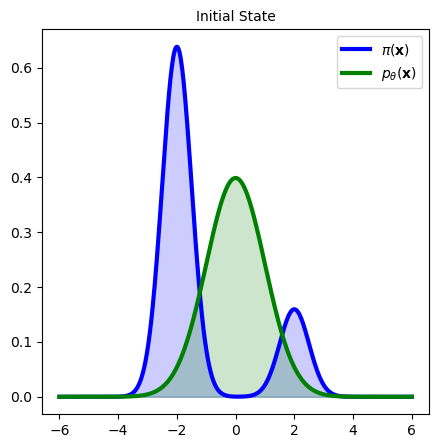

In [5]:
plot_distributions(X, mixture_gaussian.log_prob, single_gaussian.log_prob, title='Initial State')

Определим наши функции потерь.

#### Дивергенция Кульбака-Лейблера

$$D_{KL}(\pi || p) = \int \pi(\mathbf{x}) \log \frac{\pi(\mathbf{x})}{p(\mathbf{x})} d\mathbf{x}$$

**KL-дивергенция асимметрична**:

$$D_{KL}(\pi || p) \neq D_{KL}(p || \pi)$$

Поэтому мы получаем два разных вида дивергенций: **Forward KL** и **Reverse KL**.

#### Forward KL

$$D_{KL}(\pi || p) = \int \pi(\mathbf{x}) \log \frac{\pi(\mathbf{x})}{p(\mathbf{x})} d\mathbf{x}$$


In [6]:
def KLD(X, log_prob1, log_prob2):
    # (max - min) / len(X) - it's "dx"
    return (log_prob1(X).exp() * (log_prob1(X) - log_prob2(X))).sum() * (X.max() - X.min()) / len(X)

In [7]:
# Forward KL: KL(Real || Model)
forward_KL_loss_fn = lambda X, real_log_prob, model_log_prob: KLD(X, real_log_prob, model_log_prob)

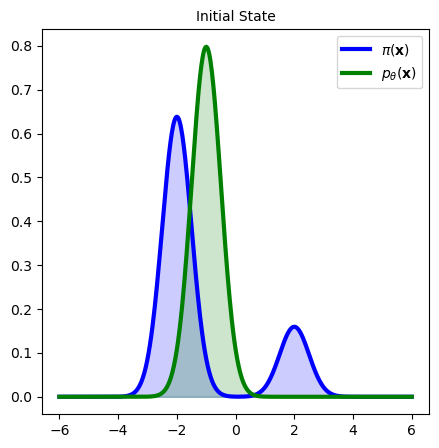

In [15]:
mu_start = -1.0
sigma_start = 0.5

mu = torch.tensor(mu_start, requires_grad=True, dtype=torch.double)
sigma = torch.tensor(sigma_start, requires_grad=True, dtype=torch.double)

single_gaussian = TD.Normal(mu, sigma)

plot_distributions(X, mixture_gaussian.log_prob, single_gaussian.log_prob, title='Initial State')

In [16]:
def solve_task(optimizer, loss_fn, real_log_prob, model_log_prob_creator, n_iters):
    for it in range(n_iters):
        optimizer.zero_grad()
        
        model_dist = model_log_prob_creator()
        
        loss = loss_fn(X, real_log_prob, model_dist.log_prob)
        loss.backward()
        optimizer.step()

        if it % 10 == 0: 
            plot_distributions(X, mixture_gaussian.log_prob,
                               model_dist.log_prob, title=f'Step: {it}, Loss: {loss:.2f}')

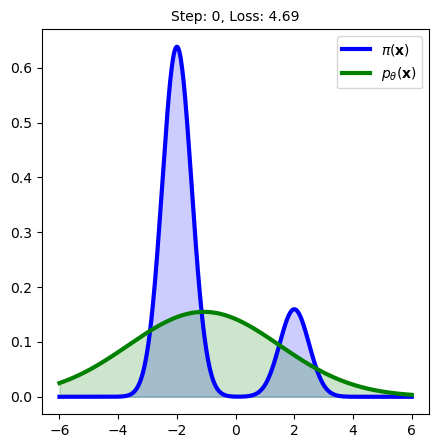

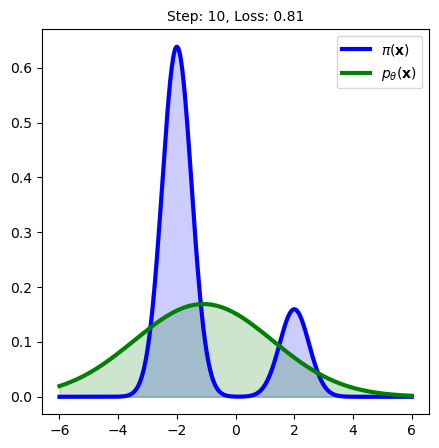

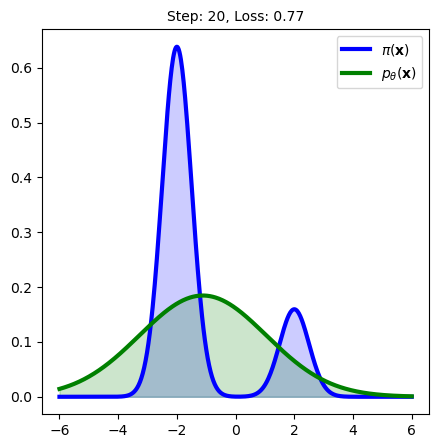

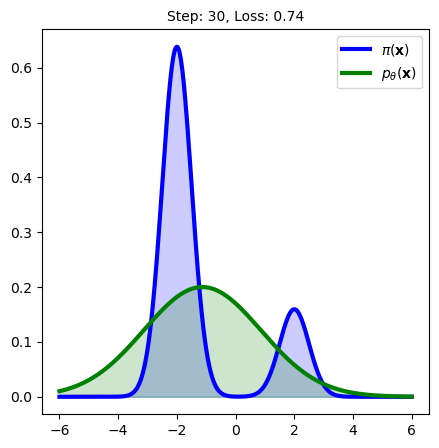

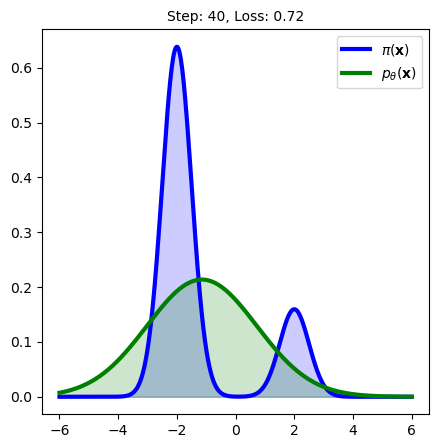

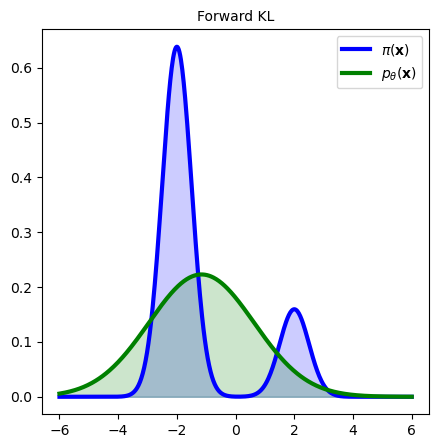

In [17]:
N_ITERS = 50
LEARNING_RATE = 0.1

mu = torch.tensor(mu_start, requires_grad=True, dtype=torch.double)
sigma = torch.tensor(sigma_start, requires_grad=True, dtype=torch.double)

def create_model():
    return TD.Normal(mu, sigma)

optimizer = torch.optim.SGD([mu, sigma], lr=LEARNING_RATE)

solve_task(optimizer, forward_KL_loss_fn, mixture_gaussian.log_prob, create_model, N_ITERS)

plot_distributions(
    X, 
    mixture_gaussian.log_prob, 
    create_model().log_prob, 
    title='Forward KL', 
)

**Поведение**:

- Если $\pi(\mathbf{x}) > 0$ (реальные данные существуют), но $p(\mathbf{x}) \to 0$, то $\log \frac{\pi(\mathbf{x})}{p(\mathbf{x})}$ взрывается до $+\infty$

- Чтобы минимизировать этот лосс, модель $p$ вынуждена размещать свою вероятностную массу везде, где есть реальные данные, то есть где $\pi(\mathbf{x}) > 0$

- Это называется **покрытием мод** (**mode-covering**), поскольку модель $p$ попытается "растянуться", чтобы покрыть обе моды $\pi$. 

#### Reverse KL

$$D_{KL}(p || \pi) = \int p(\mathbf{x}) \log \frac{p(\mathbf{x})}{\pi(\mathbf{x})} d\mathbf{x}$$

In [18]:
# Reverse KL: KL(Model || Real)
reverse_KL_loss_fn = lambda X, real_log_prob, model_log_prob: KLD(X, model_log_prob, real_log_prob)

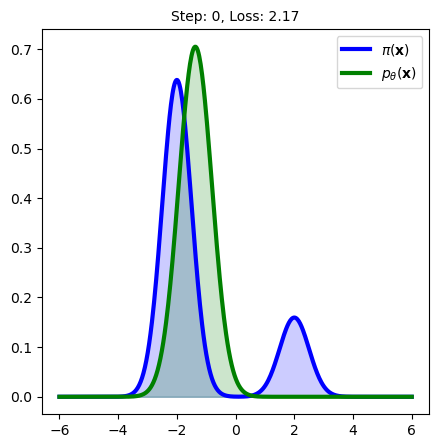

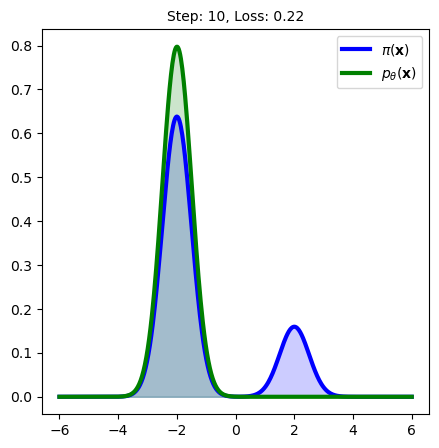

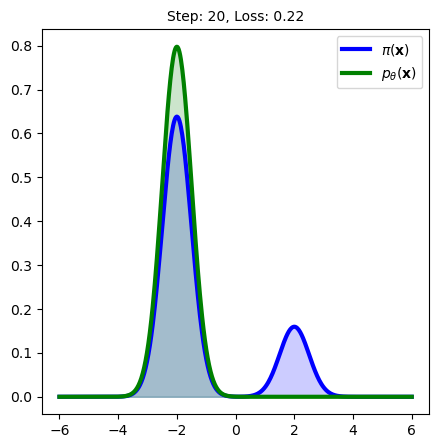

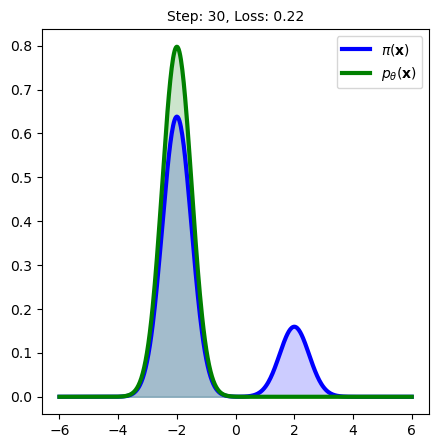

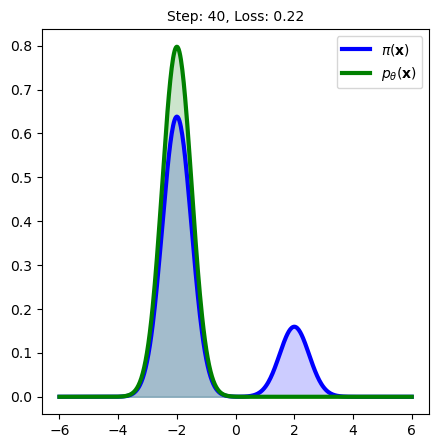

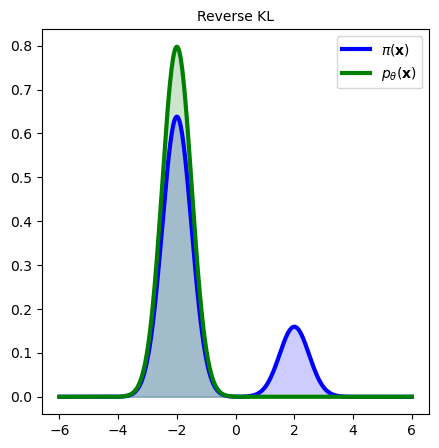

In [19]:
N_ITERS = 50
LEARNING_RATE = 0.1

mu = torch.tensor(mu_start, requires_grad=True, dtype=torch.double)
sigma = torch.tensor(sigma_start, requires_grad=True, dtype=torch.double)

optimizer = torch.optim.SGD([mu, sigma], lr=LEARNING_RATE)

solve_task(optimizer, reverse_KL_loss_fn, mixture_gaussian.log_prob, create_model, N_ITERS)

plot_distributions(
    X, 
    mixture_gaussian.log_prob, 
    create_model().log_prob, 
    title='Reverse KL',
)

**Поведение**:

- Если $p(\mathbf{x}) > 0$ (модель генерирует образец), но $\pi(\mathbf{x}) \to 0$ (этот образец "нереалистичен"), то $\log \frac{p(\mathbf{x})}{\pi(\mathbf{x})}$ взрывается до $+\infty$.

- Чтобы минимизировать эту потерю, модель $p$ вынуждена избегать генерации образцов в областях, где $\pi(\mathbf{x}) \approx 0$ и будет размещать свою массу только там, где $\pi(\mathbf{x})$ имеет высокую вероятность.

- Это называется **поиском мод** (**mode-seeking**), так как модель $p$ предпочтет найти одну моду $\pi$ с высокой вероятностью и сколлапсировать в нее (**mode collapse**)

### Jensen-Shannon Divergence

$$JSD(\pi || p) = \frac{1}{2} \left[ D_{KL}\left(\pi(\mathbf{x}) \Big|\Big| \frac{\pi(\mathbf{x}) + p(\mathbf{x})}{2}\right) + D_{KL}\left(p(\mathbf{x}) \Big|\Big| \frac{\pi(\mathbf{x}) + p(\mathbf{x})}{2}\right) \right]$$

In [20]:
def JSD(X, log_prob1, log_prob2):
    
    # log(M) = log( (exp(log_prob1) + exp(log_prob2)) / 2 )
    def log_prob_mean(x):
        prob_mean = (log_prob1(x).exp() + log_prob2(x).exp()) / 2
        return prob_mean.log()
    
    # JSD = 0.5 * KL(P1 || M) + 0.5 * KL(P2 || M)
    return (KLD(X, log_prob1, log_prob_mean) + KLD(X, log_prob2, log_prob_mean)) / 2

In [21]:
JSD_loss_fn = lambda X, real_log_prob, model_log_prob: JSD(X, real_log_prob, model_log_prob)

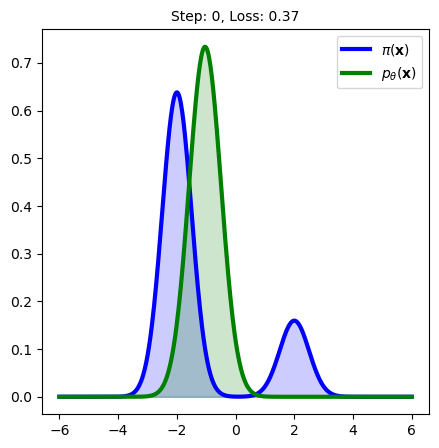

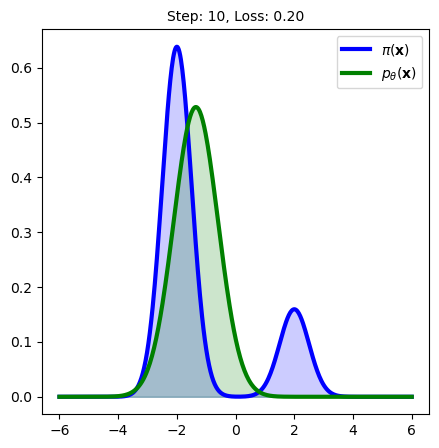

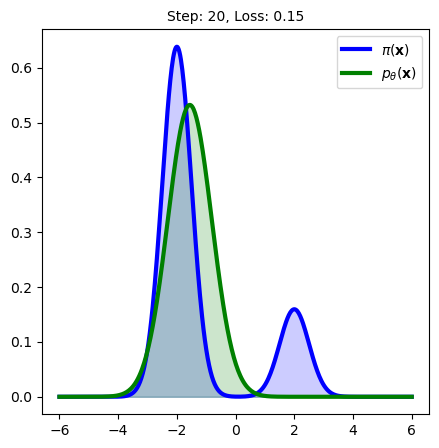

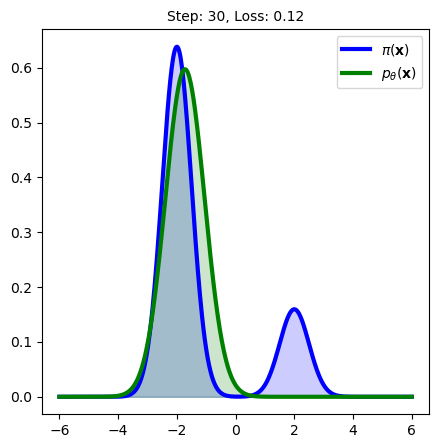

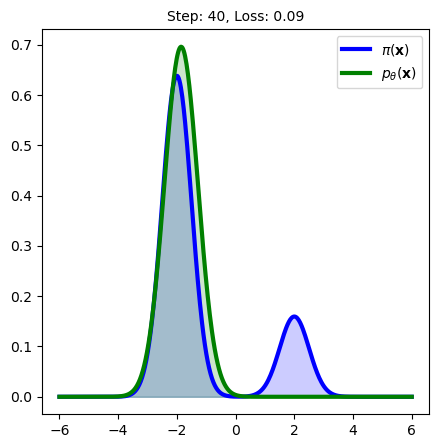

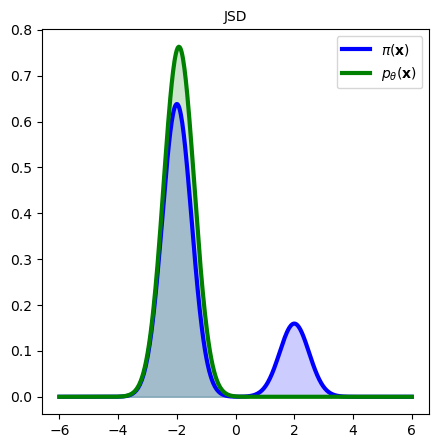

In [22]:
N_ITERS = 50
LEARNING_RATE = 0.1

mu = torch.tensor(mu_start, requires_grad=True, dtype=torch.double)
sigma = torch.tensor(sigma_start, requires_grad=True, dtype=torch.double)

optimizer = torch.optim.SGD([mu, sigma], lr=LEARNING_RATE)

solve_task(optimizer, JSD_loss_fn, mixture_gaussian.log_prob, create_model, N_ITERS)

plot_distributions(
    X, 
    mixture_gaussian.log_prob, 
    create_model().log_prob, 
    title='JSD', 
)

### Generative Adversarial Networks

Генеративно-состязательные сети (GAN) — это генеративные модели, идея которых заключается в состязательном обучении двух нейросетей:

1. **`Generator`**:

**Задача**: создавать поддельные данные, которые невозможно отличить от настоящих

**Вход**: случайный вектор $\mathbf{z}$ из латентного пространства

**Выход**: сгенерированное изображение $\hat{\mathbf{x}}$.

**Цель**: обмануть дискриминатор

2. **`Discriminator`**:

**Задача**: Определить, является ли изображение настоящим или сгенерированным

**Вход**: настоящее $\mathbf{x}$ или поддельное $\hat{\mathbf{x}}$ изображение

**Выход**: вероятность того, что изображение настоящее $p(y=1|\mathbf{x})$

**Цель**: стать как можно лучше в распознавании изображений

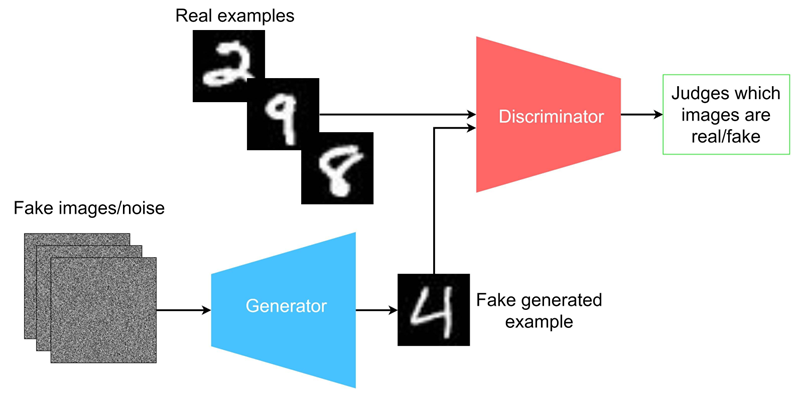


### Функция потерь

Обучение GAN — это поиск равновесия с помощью функции потерь $V(D, G)$:

$$\min_G \max_D V(D, G) = \mathbb{E}_{\mathbf{x} \sim p_{data}}[\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p_z}[\log(1 - D(G(\mathbf{z})))]$$

**`Обучение дискриминатора:`**

Дискриминатор $D$ хочет максимизировать функцию $\max_D V(D, G)$

  - $\mathbb{E}_{\mathbf{x} \sim p_{data}}[\log D(\mathbf{x})]$: для настоящих изображений $\mathbf{x}$, $D$ хочет, чтобы $D(\mathbf{x})$ было близко к 1 ($\log(1) = 0$)

  - $\mathbb{E}_{\mathbf{z} \sim p_z}[\log(1 - D(G(\mathbf{z})))]$: для поддельных изображений $G(\mathbf{z})$, $D$ хочет, чтобы $D(G(z))$ было близко к 0 (т.е. $\log(1 - 0) = 0$).

**`Обучение генератора:`**

Генератор $G$ хочет минимизировать функцию $\max_D V(D, G)$ и может влиять только на второй член

  - $\mathbb{E}_{\mathbf{z} \sim p_z}[\log(1 - D(G(\mathbf{z})))]$: $G$ хочет, чтобы $D(G(\mathbf{z}))$ было близко к 1 (чтобы $D$ ошибся). Если $D(G(\mathbf{z})) \to 1$, то $1 - D(G(\mathbf{z})) \to 0$, и $\log(0) \to -\infty$.

Посмотрим на этот процесс в одномерном пространстве

Прелесть 1D в том, что мы можем **визуализировать абсолютно всё**:

1.  **Распределение реальных данных**
2.  **Распределение шума** 
3.  **Распределение поддельных данных** 
4.  **Функцию Дискриминатора**

Нам нужно два распределения:

1.  **$\pi(x)$**: возьмем **смесь двух гауссиан**.
2.  **$p(z)$**: нормальное распределение $N(0, 1)$, из которого $G$ будет семплировать

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
latent_dim = 1   
batch_size = 32  

pi = torch.tensor([0.7, 0.3], device=device)
mu = torch.tensor([-3., 3.], device=device)
scale = torch.tensor([1., 1.], device=device)
mixture_gaussian = TD.MixtureSameFamily(
    TD.Categorical(pi), 
    TD.Normal(mu, scale)
)

def data_fn(batch_size):
    return mixture_gaussian.sample((batch_size, 1)).to(device)

def data_pdf(x):
    return mixture_gaussian.log_prob(torch.tensor(x, device=device)).exp().cpu().numpy()

def noise_fn(batch_size):
    return torch.rand(batch_size, latent_dim, device=device) - 0.5

In [25]:
class Generator(nn.Module):
    def __init__(self, hiddens):
        super().__init__()
        
        layers = []
        for in_dim, out_dim in zip(hiddens[:-1], hiddens[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            if out_dim != hiddens[-1]:
                layers.append(nn.ReLU())
        
        self.model = nn.Sequential(*layers)

    def forward(self, z):
        return self.model(z)
    
class Discriminator(nn.Module):
    def __init__(self, hiddens):
        super().__init__()
        
        layers = []
        for in_dim, out_dim in zip(hiddens[:-1], hiddens[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            if out_dim != hiddens[-1]:
                layers.append(nn.ReLU())
                
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [26]:
class VanillaGAN:
    def __init__(self, G, D, noise_fn, data_fn, device, lr_D, lr_G):
        self.G = G.to(device)
        self.D = D.to(device)
        self.noise_fn = noise_fn
        self.data_fn = data_fn
        self.device = device
        
        self.criterion = nn.BCEWithLogitsLoss()
        
        self.optim_D = optim.Adam(D.parameters(), lr=lr_D, betas=(0.5, 0.999))
        self.optim_G = optim.Adam(G.parameters(), lr=lr_G, betas=(0.5, 0.999))

    def generate_samples(self, latent_vec=None, num=None) -> torch.Tensor:
        
        num = batch_size if num is None else num
        latent_vec = self.noise_fn(num) if latent_vec is None else latent_vec
        
        with torch.no_grad():
            samples = self.G(latent_vec)
        return samples

    def train_step_D(self) -> tuple[float, float]:
        self.D.zero_grad()

        real_samples = self.data_fn(batch_size)
        current_batch_size = real_samples.size(0)
        real_targets = torch.ones(current_batch_size, 1, device=self.device)
        
        pred_real = self.D(real_samples)
        loss_real = self.criterion(pred_real, real_targets)

        latent_vec = self.noise_fn(current_batch_size)
        with torch.no_grad():
            fake_samples = self.G(latent_vec)
        
        fake_targets = torch.zeros(current_batch_size, 1, device=self.device)
        
        pred_fake = self.D(fake_samples)
        loss_fake = self.criterion(pred_fake, fake_targets)

        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self.optim_D.step()
        
        return loss_real.item(), loss_fake.item()

    def train_step_G(self) -> float:
        self.G.zero_grad()
        
        latent_vec = self.noise_fn(batch_size)
        real_targets = torch.ones(batch_size, 1, device=self.device)
        
        generated = self.G(latent_vec)
        classifications = self.D(generated)
        
        loss = self.criterion(classifications, real_targets)
        loss.backward()
        self.optim_G.step()
        
        return loss.item()

In [27]:
def visualize_GAN(noise_hist, real_hist, fake_hist=None, 
                  D_func=None, pdf_func=None, title="", 
                  is_critic=False):
    plt.figure(figsize=(8, 5))
    plt.title(title)
    
    bins = np.linspace(-7, 7, 100)
    x_axis = np.linspace(-7, 7, 200)

    plt.hist(noise_hist.flatten(), label='Noise (z)', alpha=0.5, density=True, bins=bins, color='blue')
    plt.hist(real_hist.flatten(), label='Real Data (x)', alpha=0.5, density=True, bins=bins, color='green')
    if fake_hist is not None:
        plt.hist(fake_hist.flatten(), label='Fake Data (G(z))', alpha=0.5, density=True, bins=bins, color='red')
    
    if pdf_func is not None:
        plt.plot(x_axis, pdf_func(x_axis), 'g-', label='Real PDF')
    
    if D_func is not None:
        with torch.no_grad():
            model_device = next(D_func.parameters()).device
            x_tensor = torch.from_numpy(x_axis).float().unsqueeze(-1).to(model_device)
            output_scores_tensor = D_func(x_tensor)
            
            if is_critic:
                output_scores = output_scores_tensor.cpu().numpy()
                plt.plot(x_axis, output_scores, 'b--', label='Critic Scores f(x)')   
            else:
                output_probs_tensor = torch.sigmoid(output_scores_tensor)
                output_probs = output_probs_tensor.cpu().numpy()
                
                plt.plot(x_axis, output_probs, 'b--', label='Discriminator D(x)')
                plt.ylim(0, 1.0)
                
    plt.legend(loc='upper left')
    plt.show()

In [28]:
gen_hiddens = [latent_dim, 64, 64, 64, 1]
dis_hiddens = [1, 64, 64, 64, 1]

G = Generator(gen_hiddens).to(device)
D = Discriminator(dis_hiddens).to(device)

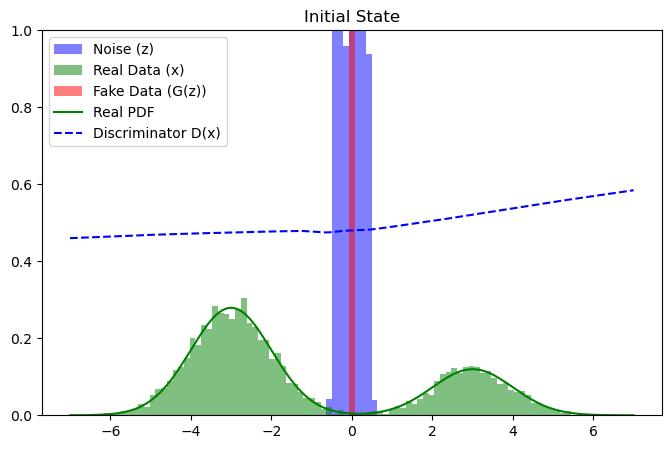

In [29]:
visualize_GAN(
    noise_fn(5000).cpu().numpy(),
    data_fn(5000).cpu().numpy(),
    G(noise_fn(5000)).detach().cpu().numpy(),
    D,
    data_pdf,
    title="Initial State"
    )

In [30]:
lr_D = 1e-3           
lr_G = 2e-4                  
epochs = 50           
batches_per_epoch = 100

gan = VanillaGAN(G, D, noise_fn, data_fn, device, lr_D, lr_G)

Epoch 1/50: G=3.911, Dr=0.072, Df=0.073


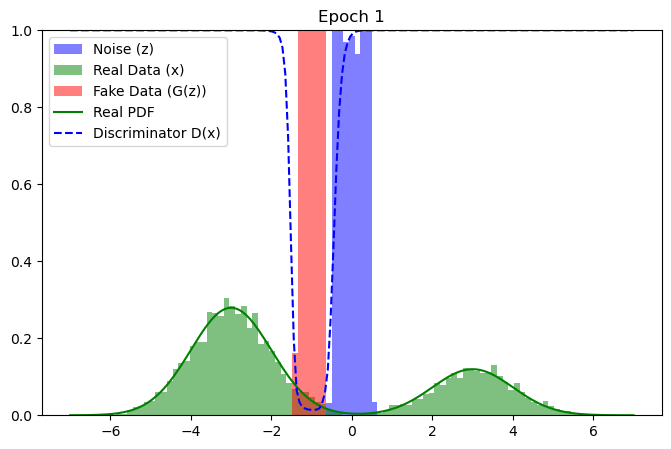

Epoch 2/50: G=2.485, Dr=0.256, Df=0.122
Epoch 3/50: G=1.357, Dr=0.482, Df=0.324
Epoch 4/50: G=1.088, Dr=0.557, Df=0.420
Epoch 5/50: G=1.013, Dr=0.580, Df=0.458


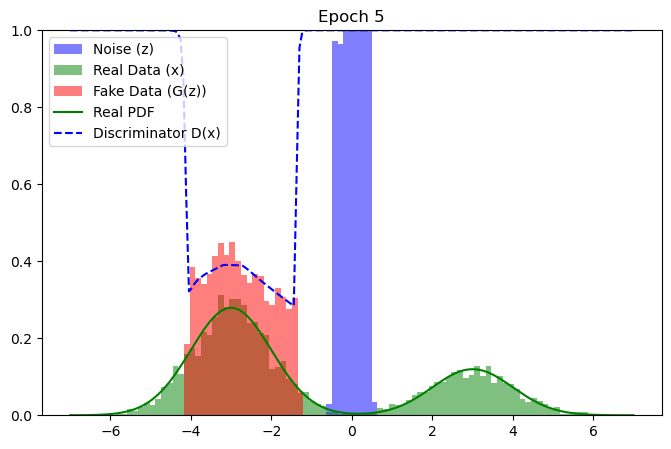

Epoch 6/50: G=0.992, Dr=0.588, Df=0.476
Epoch 7/50: G=0.971, Dr=0.596, Df=0.489
Epoch 8/50: G=0.983, Dr=0.592, Df=0.487
Epoch 9/50: G=0.974, Dr=0.594, Df=0.492
Epoch 10/50: G=0.971, Dr=0.596, Df=0.493


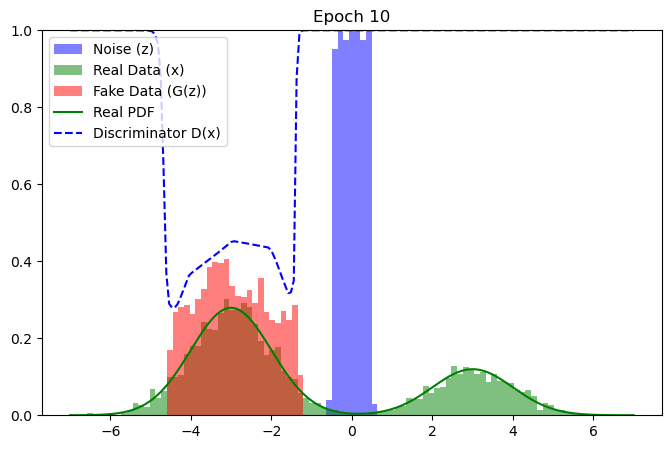

Epoch 11/50: G=0.977, Dr=0.593, Df=0.491
Epoch 12/50: G=0.976, Dr=0.594, Df=0.492
Epoch 13/50: G=0.970, Dr=0.594, Df=0.493
Epoch 14/50: G=0.970, Dr=0.596, Df=0.494
Epoch 15/50: G=0.979, Dr=0.597, Df=0.495


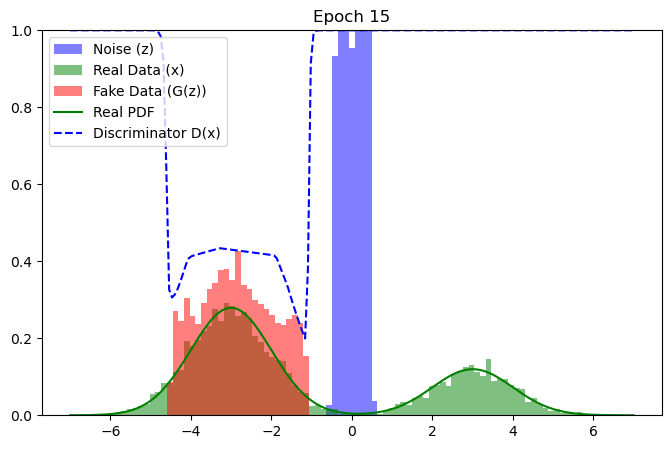

Epoch 16/50: G=0.968, Dr=0.597, Df=0.498
Epoch 17/50: G=0.965, Dr=0.594, Df=0.492
Epoch 18/50: G=0.975, Dr=0.594, Df=0.491
Epoch 19/50: G=0.963, Dr=0.598, Df=0.494
Epoch 20/50: G=0.962, Dr=0.597, Df=0.497


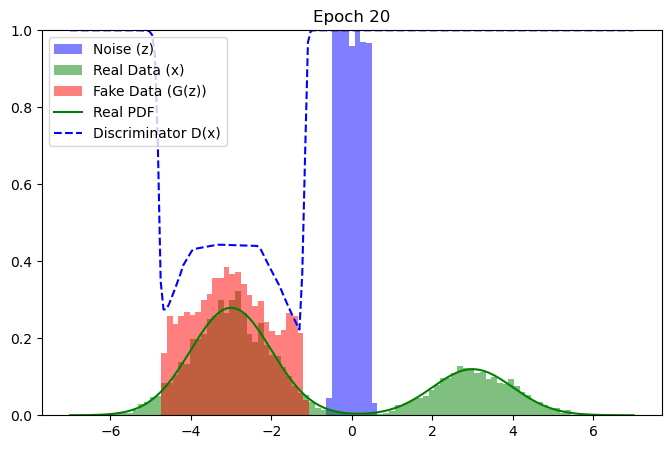

Epoch 21/50: G=0.953, Dr=0.598, Df=0.503
Epoch 22/50: G=0.968, Dr=0.597, Df=0.500
Epoch 23/50: G=0.960, Dr=0.597, Df=0.498
Epoch 24/50: G=0.973, Dr=0.595, Df=0.493
Epoch 25/50: G=0.968, Dr=0.597, Df=0.497


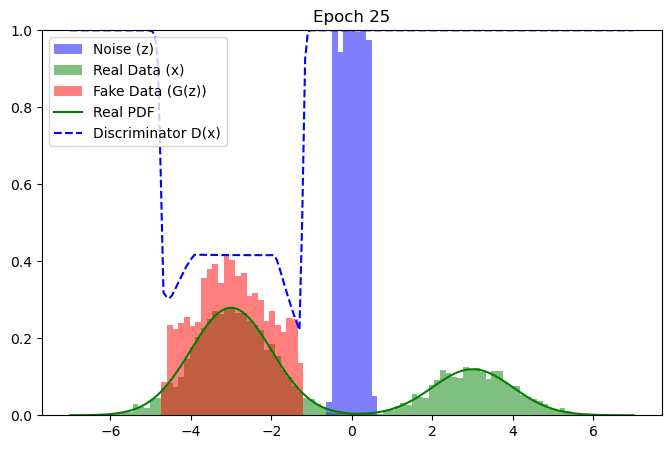

Epoch 26/50: G=0.960, Dr=0.597, Df=0.494
Epoch 27/50: G=0.955, Dr=0.597, Df=0.499
Epoch 28/50: G=0.948, Dr=0.601, Df=0.499
Epoch 29/50: G=0.970, Dr=0.595, Df=0.495
Epoch 30/50: G=0.950, Dr=0.602, Df=0.503


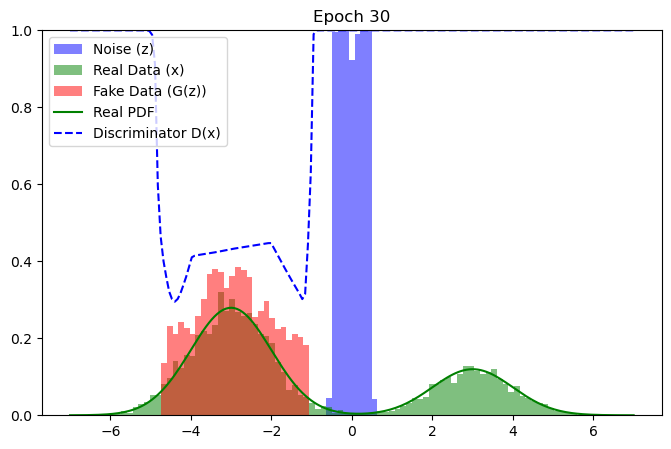

Epoch 31/50: G=0.948, Dr=0.603, Df=0.504
Epoch 32/50: G=0.946, Dr=0.602, Df=0.503
Epoch 33/50: G=0.953, Dr=0.599, Df=0.497
Epoch 34/50: G=0.955, Dr=0.600, Df=0.500
Epoch 35/50: G=0.957, Dr=0.601, Df=0.502


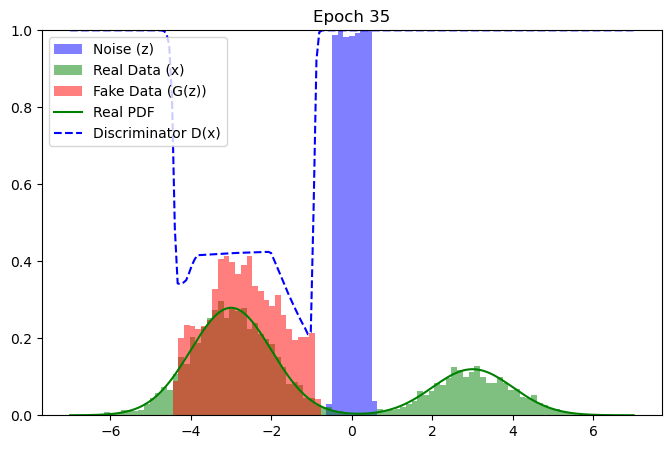

Epoch 36/50: G=0.952, Dr=0.602, Df=0.504
Epoch 37/50: G=0.946, Dr=0.602, Df=0.507
Epoch 38/50: G=0.945, Dr=0.605, Df=0.505
Epoch 39/50: G=0.946, Dr=0.603, Df=0.506
Epoch 40/50: G=0.942, Dr=0.604, Df=0.504


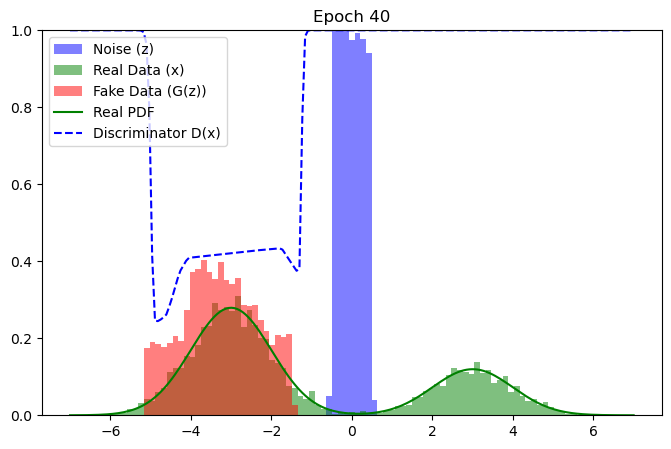

Epoch 41/50: G=0.945, Dr=0.605, Df=0.505
Epoch 42/50: G=0.946, Dr=0.601, Df=0.504
Epoch 43/50: G=0.940, Dr=0.607, Df=0.507
Epoch 44/50: G=0.938, Dr=0.604, Df=0.505
Epoch 45/50: G=0.942, Dr=0.603, Df=0.506


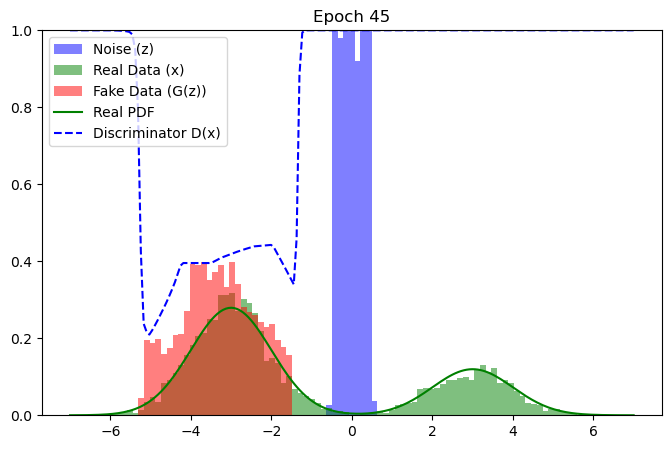

Epoch 46/50: G=0.956, Dr=0.599, Df=0.499
Epoch 47/50: G=0.942, Dr=0.609, Df=0.505
Epoch 48/50: G=0.938, Dr=0.606, Df=0.508
Epoch 49/50: G=0.942, Dr=0.604, Df=0.507
Epoch 50/50: G=0.953, Dr=0.609, Df=0.508


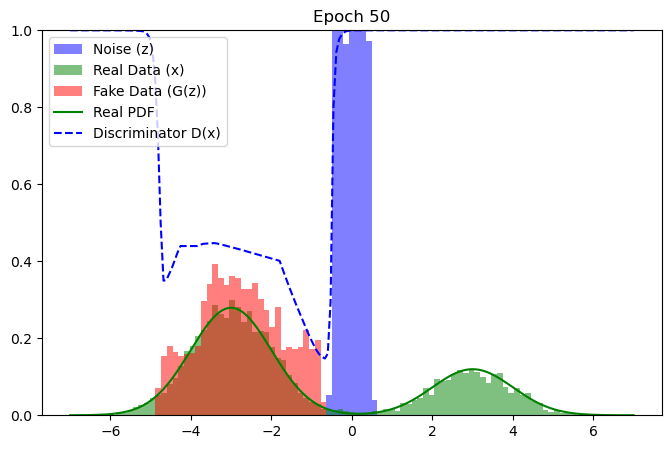

In [31]:
k_steps_D = 5

for epoch in range(epochs):
    
    loss_g_running = 0.0
    loss_d_real_running = 0.0
    loss_d_fake_running = 0.0
    
    for i in range(batches_per_epoch):
        
        # Train the Discriminator n_D_steps times
        for _ in range(k_steps_D):
            ldr_, ldf_ = gan.train_step_D() 
            loss_d_real_running += ldr_
            loss_d_fake_running += ldf_

        # Train the Generator 1 time
        lg_ = gan.train_step_G()
        loss_g_running += lg_
    
    avg_g_loss = loss_g_running / batches_per_epoch
    avg_d_real_loss = loss_d_real_running / (batches_per_epoch * k_steps_D)
    avg_d_fake_loss = loss_d_fake_running / (batches_per_epoch * k_steps_D)
    
    print(f"Epoch {epoch+1}/{epochs}: "
          f"G={avg_g_loss:.3f}, Dr={avg_d_real_loss:.3f}, Df={avg_d_fake_loss:.3f}")

    if epoch == 0 or (epoch+1) % 5 == 0:
        visualize_GAN(
            noise_fn(5000).cpu().numpy(),
            data_fn(5000).cpu().numpy(),
            gan.generate_samples(num=5000).cpu().numpy(),
            gan.D,
            data_pdf,
            title=f"Epoch {epoch+1}"
        )

### Wasserstein GAN

В модели `WGAN` предложили использовать другую метрику — **Расстояние Вассерштейна** $W(\pi, p)$.

В непрерывном случае расстояние Вассерштейна $W$ определяется следующим образом:

$$W(\pi, p_g) = \inf_{\gamma \in \Gamma(\pi, p_g)} \mathbb{E}_{(x, y) \sim \gamma} [\|x - y\|]$$

Однако вычислить $W$ напрямую (найти самый эффективный транспортный план) — невозможно.

Поэтому мы используем **двойственность Канторовича-Рубинштейна**. Вместо поиска $\inf$, теорема предлагает искать $\max$ по всем $K$-Липшицевым функциям $f$:

$$W(\pi, p_g) = \frac{1}{K} \max_{\|f\|_L \le K} \left( \mathbb{E}_{x \sim \pi}[f(x)] - \mathbb{E}_{x \sim p}[f(x)] \right)$$

$K$-Липшицева функция — это функция, градиент которой везде ограничен константой $K$:

$$|f(x_1) - f(x_2)| \le K |x_1 - x_2|$$

Мы заменяем **Дискриминатор** на **Критика** (**Critic**), $f_\phi$.

Критик $f_\phi$ теперь выдает не вероятность, а любое вещественное число — **оценку** (**score**).

**Как заставить нашу нейросеть $f_\phi$ быть $1$-Липшицевой?**

После каждого шага градиентного спуска Критика мы принудительно обрезаем все его веса, заставляя их находиться в небольшом диапазоне $[-c, c]$. Это называется **обрезкой весов** (**Weight Clipping**)

In [32]:
class Generator(nn.Module):
    def __init__(self, hiddens):
        super().__init__()
        layers = []
        for in_dim, out_dim in zip(hiddens[:-1], hiddens[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            if out_dim != hiddens[-1]:
                layers.append(nn.ReLU())
        self.model = nn.Sequential(*layers)

    def forward(self, z):
        return self.model(z)

class Critic(nn.Module):
    def __init__(self, hiddens):
        super().__init__()
        layers = []
        for in_dim, out_dim in zip(hiddens[:-1], hiddens[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            if out_dim != hiddens[-1]:
                layers.append(nn.ReLU())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [33]:
class WGAN:
    def __init__(self, G, C, noise_fn, data_fn, device, n_critic, clip_c, lr):
        self.G = G.to(device)
        self.C = C.to(device)
        self.noise_fn = noise_fn
        self.data_fn = data_fn
        self.device = device
        self.n_critic = n_critic
        self.clip_c = clip_c
        
        self.optim_C = optim.Adam(C.parameters(), lr=lr, betas=(0.5, 0.9))
        self.optim_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.9))

    def generate_samples(self, latent_vec=None, num=None) -> torch.Tensor:
        num = batch_size if num is None else num
        latent_vec = self.noise_fn(num) if latent_vec is None else latent_vec
        with torch.no_grad():
            samples = self.G(latent_vec)
        return samples

    def train_step_C(self) -> tuple[float, float]:
        self.C.zero_grad()

        # Real Data
        real_samples = self.data_fn(batch_size)
        real_scores = self.C(real_samples)

        # Fake Data
        latent_vec = self.noise_fn(batch_size)
        with torch.no_grad():
            fake_samples = self.G(latent_vec)
        fake_scores = self.C(fake_samples)

        # Loss: max [E[f(x)] - E[f(G(z))]]
        loss_C = (fake_scores.mean()) - (real_scores.mean())
        
        loss_C.backward()
        self.optim_C.step()

        # Weight Clipping
        for p in self.C.parameters():
            p.data.clamp_(-self.clip_c, self.clip_c)
        
        return real_scores.mean().item(), fake_scores.mean().item()

    def train_step_G(self) -> float:
        self.G.zero_grad()
        
        latent_vec = self.noise_fn(batch_size)
        fake_samples = self.G(latent_vec)
        fake_scores = self.C(fake_samples)

        # Loss: min [-E[f(G(z))]]
        loss_G = -fake_scores.mean()
        
        loss_G.backward()
        self.optim_G.step()
        
        return loss_G.item()

In [34]:
generator = Generator(gen_hiddens).to(device)
critic = Critic(dis_hiddens).to(device)

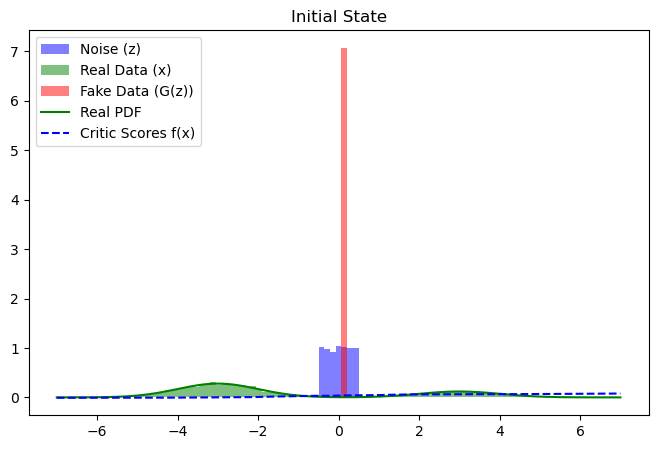

In [35]:
visualize_GAN(
    noise_fn(5000).cpu().numpy(),
    data_fn(5000).cpu().numpy(),
    generator(noise_fn(5000)).detach().cpu().numpy(),
    critic,
    data_pdf,
    title="Initial State",
    is_critic=True
)

In [36]:
lr = 1e-4
batch_size = 32
latent_dim = 1
n_critic = 5
clip_c = 0.1         
epochs = 50
batches_per_epoch = 100

gen_hiddens = [latent_dim, 64, 64, 64, 1]
dis_hiddens = [1, 64, 64, 64, 1]

gan = WGAN(generator, critic, noise_fn, data_fn, device, n_critic, clip_c, lr)

Epoch 1/50: G=0.094, C_real=0.351, C_fake=-0.091, W_Dist=0.442
Epoch 2/50: G=0.618, C_real=1.539, C_fake=-0.611, W_Dist=2.150
Epoch 3/50: G=0.869, C_real=2.657, C_fake=-0.859, W_Dist=3.517
Epoch 4/50: G=0.990, C_real=1.901, C_fake=-0.964, W_Dist=2.865
Epoch 5/50: G=3.231, C_real=-0.049, C_fake=-3.224, W_Dist=3.175


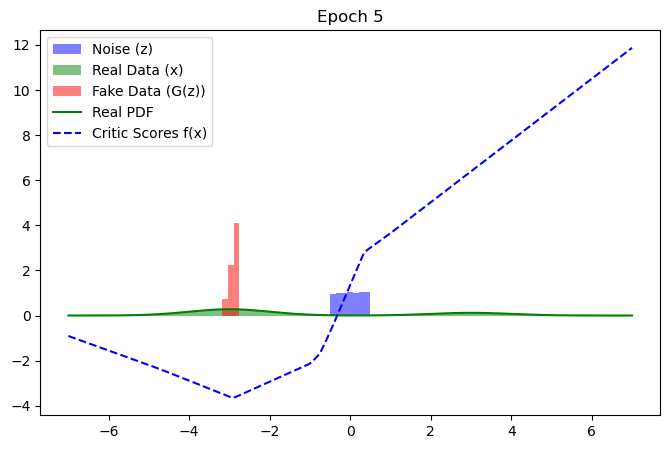

Epoch 6/50: G=3.675, C_real=-0.109, C_fake=-3.673, W_Dist=3.564
Epoch 7/50: G=3.781, C_real=-0.121, C_fake=-3.780, W_Dist=3.659
Epoch 8/50: G=3.916, C_real=-0.229, C_fake=-3.908, W_Dist=3.679
Epoch 9/50: G=3.967, C_real=-0.249, C_fake=-3.961, W_Dist=3.712
Epoch 10/50: G=3.916, C_real=-0.147, C_fake=-3.916, W_Dist=3.769


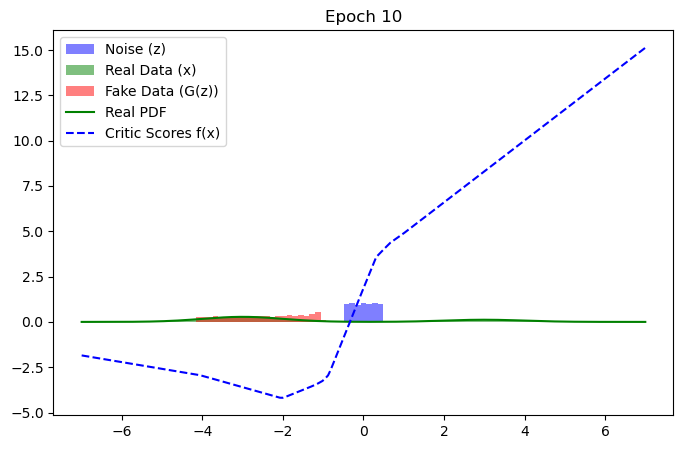

Epoch 11/50: G=3.395, C_real=0.180, C_fake=-3.409, W_Dist=3.589
Epoch 12/50: G=2.201, C_real=1.298, C_fake=-2.162, W_Dist=3.460
Epoch 13/50: G=1.085, C_real=1.917, C_fake=-1.076, W_Dist=2.993
Epoch 14/50: G=0.266, C_real=1.906, C_fake=-0.341, W_Dist=2.246
Epoch 15/50: G=-0.383, C_real=2.068, C_fake=0.392, W_Dist=1.676


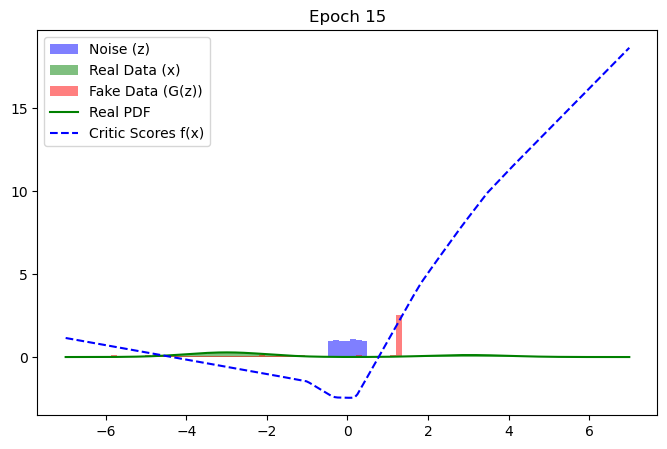

Epoch 16/50: G=-0.712, C_real=1.793, C_fake=0.716, W_Dist=1.076
Epoch 17/50: G=-0.560, C_real=1.068, C_fake=0.609, W_Dist=0.459
Epoch 18/50: G=2.203, C_real=-1.591, C_fake=-2.205, W_Dist=0.614
Epoch 19/50: G=2.784, C_real=-1.964, C_fake=-2.763, W_Dist=0.799
Epoch 20/50: G=1.925, C_real=-1.362, C_fake=-1.977, W_Dist=0.615


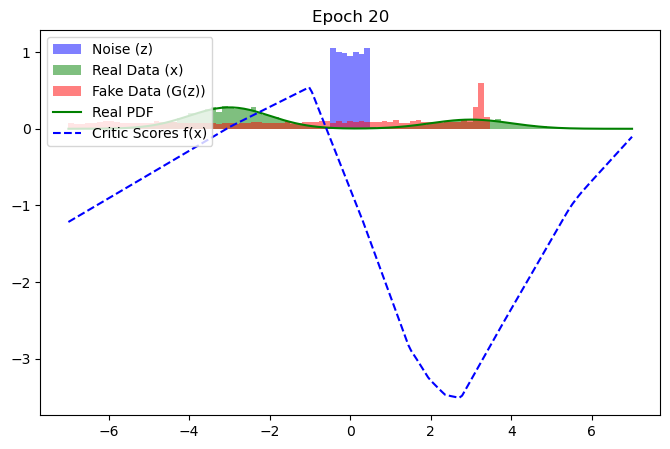

Epoch 21/50: G=0.577, C_real=-0.157, C_fake=-0.620, W_Dist=0.463
Epoch 22/50: G=0.374, C_real=0.032, C_fake=-0.373, W_Dist=0.406
Epoch 23/50: G=0.801, C_real=-0.406, C_fake=-0.787, W_Dist=0.381
Epoch 24/50: G=-0.226, C_real=0.609, C_fake=0.232, W_Dist=0.377
Epoch 25/50: G=0.172, C_real=0.261, C_fake=-0.123, W_Dist=0.384


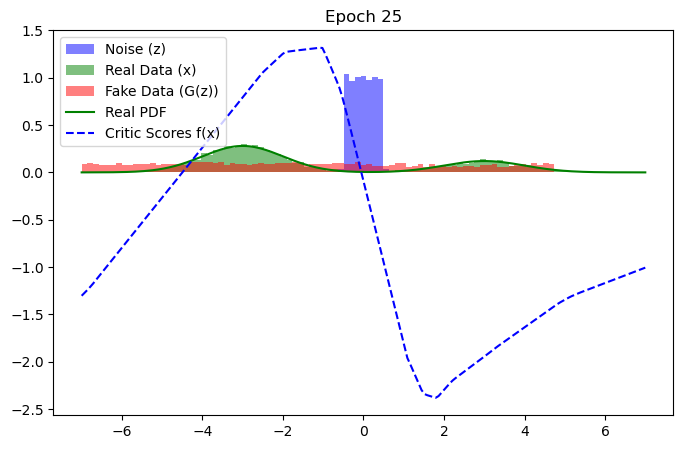

Epoch 26/50: G=-0.142, C_real=0.452, C_fake=0.139, W_Dist=0.313
Epoch 27/50: G=-0.763, C_real=1.112, C_fake=0.756, W_Dist=0.356
Epoch 28/50: G=-0.328, C_real=0.652, C_fake=0.333, W_Dist=0.319
Epoch 29/50: G=-0.537, C_real=0.887, C_fake=0.569, W_Dist=0.318
Epoch 30/50: G=-0.412, C_real=0.705, C_fake=0.407, W_Dist=0.298


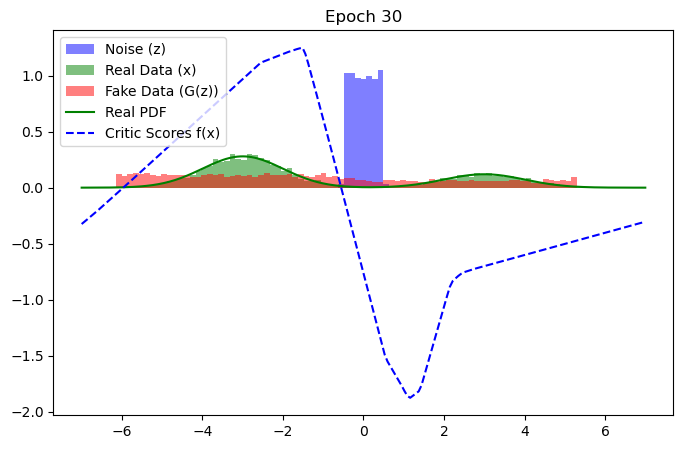

Epoch 31/50: G=-0.264, C_real=0.540, C_fake=0.229, W_Dist=0.310
Epoch 32/50: G=-0.360, C_real=0.654, C_fake=0.360, W_Dist=0.294
Epoch 33/50: G=0.108, C_real=0.203, C_fake=-0.110, W_Dist=0.312
Epoch 34/50: G=-0.221, C_real=0.490, C_fake=0.209, W_Dist=0.281
Epoch 35/50: G=-0.320, C_real=0.614, C_fake=0.337, W_Dist=0.278


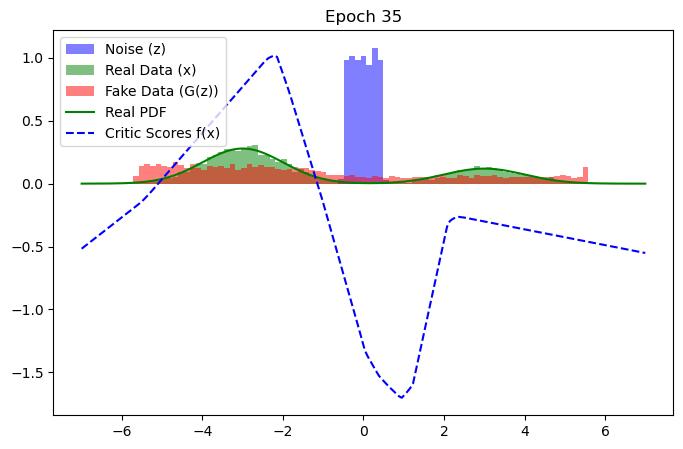

Epoch 36/50: G=-0.158, C_real=0.432, C_fake=0.156, W_Dist=0.276
Epoch 37/50: G=-0.481, C_real=0.746, C_fake=0.486, W_Dist=0.260
Epoch 38/50: G=-0.429, C_real=0.681, C_fake=0.445, W_Dist=0.236
Epoch 39/50: G=-0.334, C_real=0.578, C_fake=0.347, W_Dist=0.231
Epoch 40/50: G=-0.535, C_real=0.718, C_fake=0.512, W_Dist=0.205


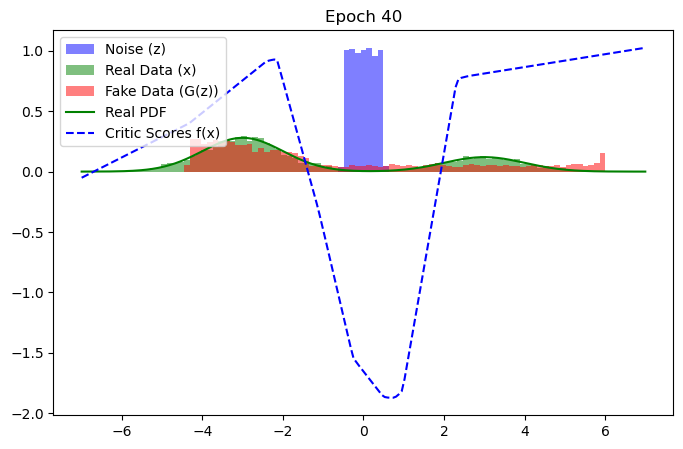

Epoch 41/50: G=-0.451, C_real=0.639, C_fake=0.431, W_Dist=0.208
Epoch 42/50: G=-0.444, C_real=0.691, C_fake=0.494, W_Dist=0.197
Epoch 43/50: G=-0.559, C_real=0.774, C_fake=0.572, W_Dist=0.203
Epoch 44/50: G=-0.508, C_real=0.721, C_fake=0.518, W_Dist=0.203
Epoch 45/50: G=-0.159, C_real=0.361, C_fake=0.150, W_Dist=0.211


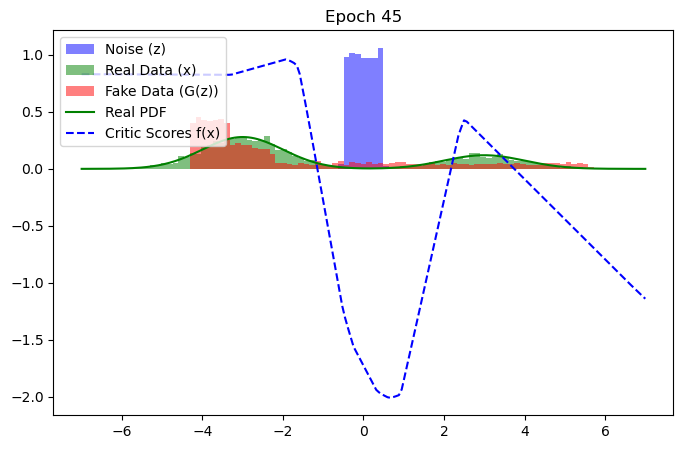

Epoch 46/50: G=-0.502, C_real=0.744, C_fake=0.536, W_Dist=0.208
Epoch 47/50: G=-0.315, C_real=0.530, C_fake=0.308, W_Dist=0.222
Epoch 48/50: G=-0.060, C_real=0.255, C_fake=0.040, W_Dist=0.215
Epoch 49/50: G=-0.249, C_real=0.442, C_fake=0.223, W_Dist=0.218
Epoch 50/50: G=-0.222, C_real=0.435, C_fake=0.218, W_Dist=0.216


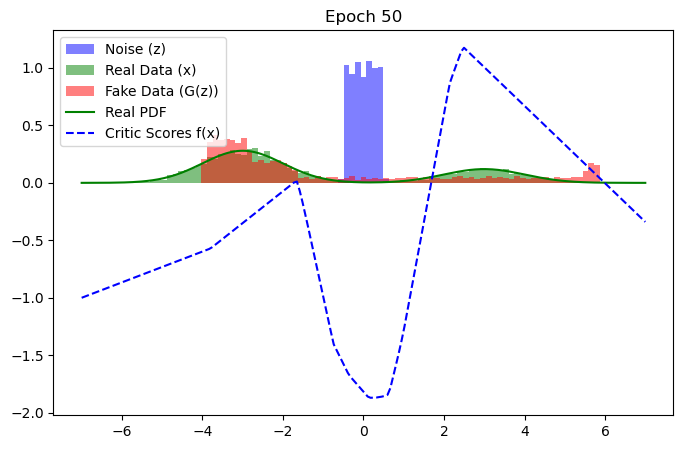

In [37]:
for epoch in range(epochs):
    
    loss_g_running = 0.0
    loss_c_real_running = 0.0
    loss_c_fake_running = 0.0
    
    for i in range(batches_per_epoch):
        
        # Train the Discriminator n_critic times
        for _ in range(n_critic):
            lcr_, lcf_ = gan.train_step_C()
            loss_c_real_running += lcr_
            loss_c_fake_running += lcf_

        # Train the Generator 1 time
        lg_ = gan.train_step_G()
        loss_g_running += lg_
    
    avg_g_loss = loss_g_running / batches_per_epoch
    avg_c_real_loss = loss_c_real_running / (batches_per_epoch * n_critic)
    avg_c_fake_loss = loss_c_fake_running / (batches_per_epoch * n_critic)
    
    wasserstein_dist = avg_c_real_loss - avg_c_fake_loss
    
    print(f"Epoch {epoch+1}/{epochs}: "
          f"G={avg_g_loss:.3f}, C_real={avg_c_real_loss:.3f}, C_fake={avg_c_fake_loss:.3f}, "
          f"W_Dist={wasserstein_dist:.3f}")

    if (epoch+1) % 5 == 0:
        visualize_GAN(
            noise_fn(5000).cpu().numpy(),
            data_fn(5000).cpu().numpy(),
            gan.generate_samples(num=5000).cpu().numpy(),
            gan.C,
            data_pdf,
            title=f"Epoch {epoch+1}",
            is_critic=True
        )

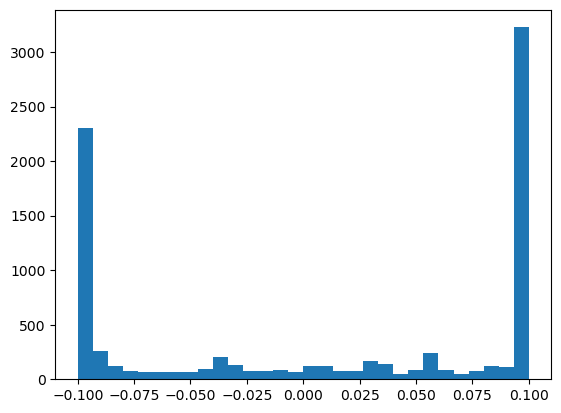

In [38]:
params = []
for param in critic.parameters():
    params.extend(param.detach().cpu().numpy().flatten())
plt.hist(params, bins=30)
plt.show()

### WGAN-GP

**`Weight Clipping`** — очень грубый метод обеспечения 1-Липшицевости

В `WGAN-GP` вместо грубой обрезки весов, авторы предложили наказывать Критика, если он перестает быть 1-Липшицевым.

Мы берем старую функцию потерь WGAN и добавляем к ней **Gradient Penalty**.

$$L_{Critic} = \underbrace{\left( \mathbb{E}_{x' \sim p_g}[f_\phi(x')] - \mathbb{E}_{x \sim \pi}[f_\phi(x)] \right)}_{\text{ WGAN Loss}} + \underbrace{\lambda_{gp} \cdot \mathbb{E}_{\hat{x} \sim p(\hat{x})} \left[ (\|\nabla_{\hat{x}} f_\phi(\hat{x})\|_2 - 1)^2 \right]}_{\text{Gradient Penalty}}$$

- $\|\nabla_{\hat{x}} f_\phi(\hat{x})\|_2$: $L_2$-норма градиента Критика в случайной точке $\hat{x}$.

- $\lambda_{gp}$: коэффициент который определяет, насколько важен **Gradient Penalty**

- $\hat{x}$: случайный образец между реальными ($x \sim \pi$) и поддельными ($x' \sim p_g$) данными:

$$
\hat{x} = \epsilon \cdot x + (1 - \epsilon) x'
$$

где $x \sim \pi$, $x' \sim p_g$, и $\epsilon \sim U[0, 1]$.

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lr = 5e-5           
batch_size = 32
latent_dim = 1
n_critic = 5            
epochs = 50
batches_per_epoch = 100

gen_hiddens = [latent_dim, 64, 64, 64, 1] 
dis_hiddens = [1, 64, 64, 64, 1]          

In [45]:
class WGAN_GP:
    def __init__(self, G, C, noise_fn, data_fn, device, n_critic, lambda_gp, lr):
        self.G = G.to(device)
        self.C = C.to(device)
        self.noise_fn = noise_fn
        self.data_fn = data_fn
        self.device = device
        self.n_critic = n_critic
        self.lambda_gp = lambda_gp
        
        self.optim_C = optim.Adam(C.parameters(), lr=lr, betas=(0.5, 0.9))
        self.optim_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.9))

    def generate_samples(self, latent_vec=None, num=None) -> torch.Tensor:
        num = batch_size if num is None else num
        latent_vec = self.noise_fn(num) if latent_vec is None else latent_vec
        with torch.no_grad():
            samples = self.G(latent_vec)
        return samples

    def compute_gradient_penalty(self, real_samples, fake_samples):
        alpha = torch.rand(real_samples.size(0), 1, device=self.device)
        interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
        
        critic_interpolates = self.C(interpolates)
        
        fake_grad_outputs = torch.ones_like(critic_interpolates, device=self.device)
        
        gradients = autograd.grad(
            outputs=critic_interpolates,
            inputs=interpolates,
            grad_outputs=fake_grad_outputs,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]
        
        gradients = gradients.view(gradients.size(0), -1)
        gradient_norm = gradients.norm(2, dim=1)
        
        gradient_penalty = ((gradient_norm - 1) ** 2).mean()
        return gradient_penalty

    def train_step_C(self) -> tuple[float, float, float]:
        self.C.zero_grad()

        real_samples = self.data_fn(batch_size)
        real_scores = self.C(real_samples)

        latent_vec = self.noise_fn(batch_size)
        with torch.no_grad():
            fake_samples = self.G(latent_vec)
        fake_scores = self.C(fake_samples)

        # Loss: max [E[f(x)] - E[f(G(z))]]
        loss_C_original = (fake_scores.mean()) - (real_scores.mean())
        
        gp = self.compute_gradient_penalty(real_samples, fake_samples)
        
        loss_C = loss_C_original + self.lambda_gp * gp
        
        loss_C.backward()
        self.optim_C.step()
        
        return real_scores.mean().item(), fake_scores.mean().item(), gp.item()

    def train_step_G(self) -> float:
        self.G.zero_grad()
        
        latent_vec = self.noise_fn(batch_size)
        fake_samples = self.G(latent_vec)
        fake_scores = self.C(fake_samples)

        loss_G = -fake_scores.mean()
        
        loss_G.backward()
        self.optim_G.step()
        
        return loss_G.item()

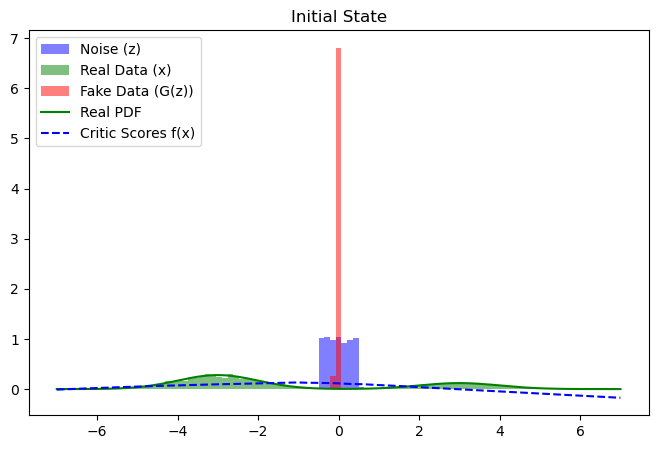

In [46]:
G = Generator(gen_hiddens).to(device)
C = Critic(dis_hiddens).to(device)

visualize_GAN(
    noise_fn(5000).cpu().numpy(),
    data_fn(5000).cpu().numpy(),
    G(noise_fn(5000)).detach().cpu().numpy(),
    C,
    data_pdf,
    title="Initial State",
    is_critic=True
)

In [47]:
lambda_gp = 5
gan = WGAN_GP(G, C, noise_fn, data_fn, device, n_critic, lambda_gp, lr)

Epoch 1/50: G=0.217, C_real=-0.941, C_fake=-0.213, W_Dist=-0.728, GP=0.509


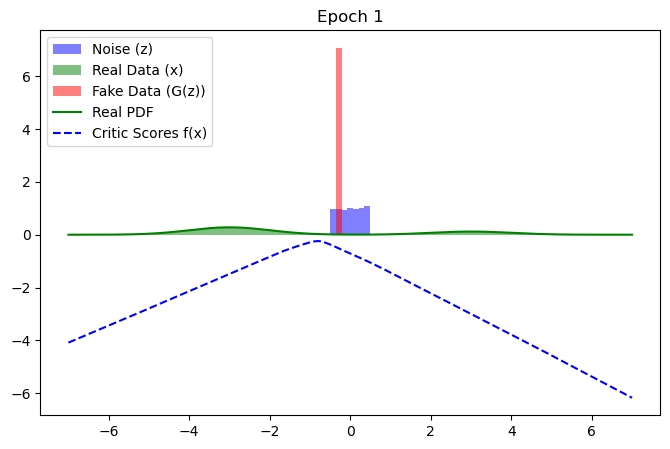

Epoch 2/50: G=0.780, C_real=-1.900, C_fake=-0.776, W_Dist=-1.124, GP=0.164
Epoch 3/50: G=1.357, C_real=-1.708, C_fake=-1.351, W_Dist=-0.357, GP=0.218
Epoch 4/50: G=1.850, C_real=-1.599, C_fake=-1.848, W_Dist=0.249, GP=0.224
Epoch 5/50: G=1.744, C_real=-1.089, C_fake=-1.741, W_Dist=0.652, GP=0.105


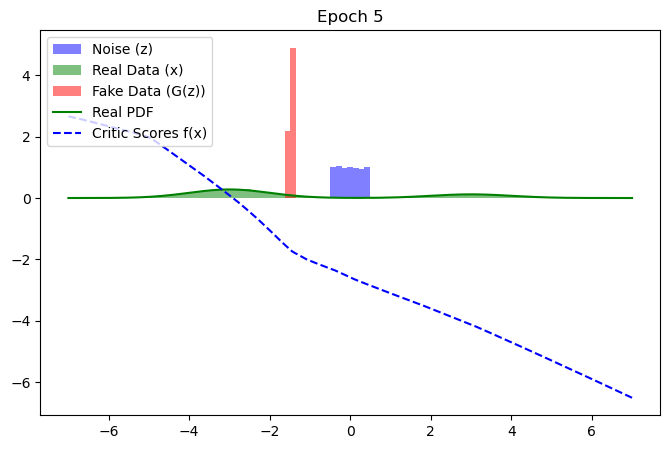

Epoch 6/50: G=1.682, C_real=-1.455, C_fake=-1.679, W_Dist=0.224, GP=0.091
Epoch 7/50: G=1.696, C_real=-1.983, C_fake=-1.691, W_Dist=-0.292, GP=0.092
Epoch 8/50: G=1.534, C_real=-2.368, C_fake=-1.528, W_Dist=-0.840, GP=0.104
Epoch 9/50: G=1.140, C_real=-2.526, C_fake=-1.136, W_Dist=-1.390, GP=0.133
Epoch 10/50: G=-0.009, C_real=-0.672, C_fake=0.003, W_Dist=-0.675, GP=0.206


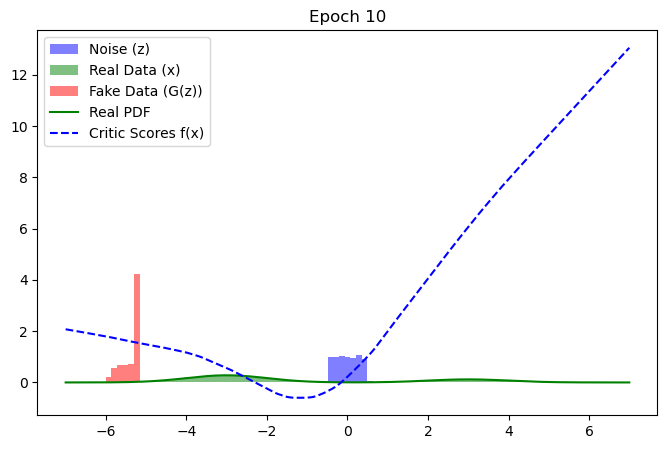

Epoch 11/50: G=-3.649, C_real=3.968, C_fake=3.629, W_Dist=0.339, GP=0.366
Epoch 12/50: G=-4.589, C_real=5.319, C_fake=4.597, W_Dist=0.722, GP=0.483
Epoch 13/50: G=1.645, C_real=4.756, C_fake=-1.589, W_Dist=6.346, GP=0.467
Epoch 14/50: G=4.671, C_real=3.707, C_fake=-4.674, W_Dist=8.381, GP=0.336
Epoch 15/50: G=2.980, C_real=3.066, C_fake=-2.995, W_Dist=6.061, GP=0.211


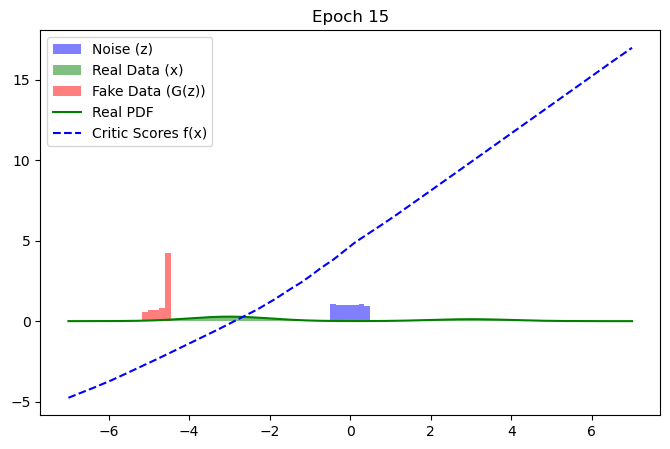

Epoch 16/50: G=1.498, C_real=2.947, C_fake=-1.508, W_Dist=4.456, GP=0.145
Epoch 17/50: G=0.194, C_real=2.947, C_fake=-0.194, W_Dist=3.142, GP=0.106
Epoch 18/50: G=-0.807, C_real=3.062, C_fake=0.805, W_Dist=2.257, GP=0.094
Epoch 19/50: G=-1.402, C_real=2.939, C_fake=1.404, W_Dist=1.535, GP=0.085
Epoch 20/50: G=-1.711, C_real=2.753, C_fake=1.713, W_Dist=1.041, GP=0.081


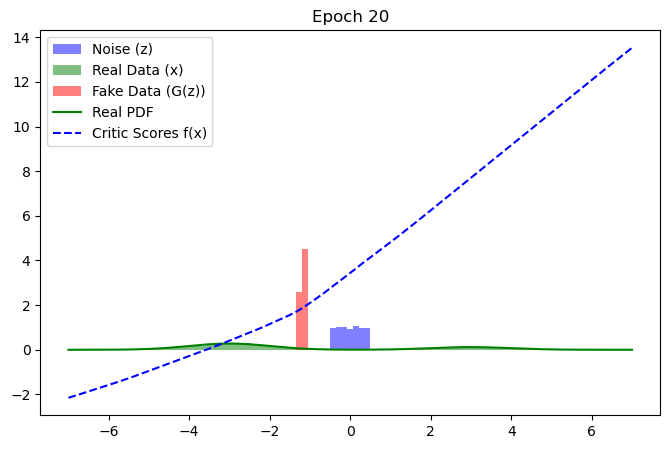

Epoch 21/50: G=-1.937, C_real=2.473, C_fake=1.939, W_Dist=0.534, GP=0.077
Epoch 22/50: G=-2.092, C_real=2.360, C_fake=2.094, W_Dist=0.267, GP=0.080
Epoch 23/50: G=-2.253, C_real=2.323, C_fake=2.254, W_Dist=0.069, GP=0.084
Epoch 24/50: G=-2.374, C_real=2.242, C_fake=2.374, W_Dist=-0.132, GP=0.086
Epoch 25/50: G=-2.458, C_real=2.252, C_fake=2.458, W_Dist=-0.206, GP=0.092


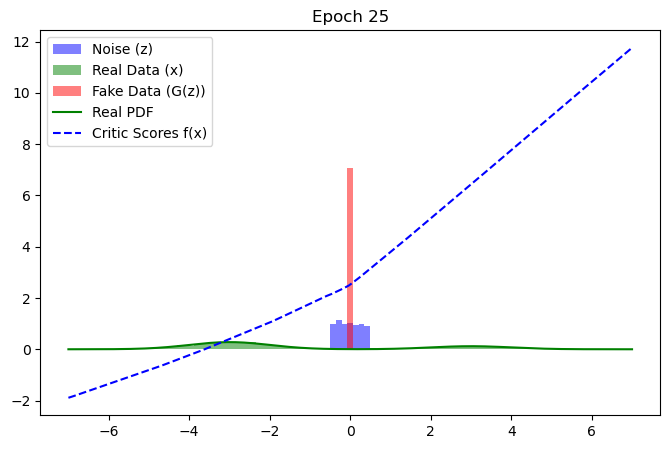

Epoch 26/50: G=-2.532, C_real=2.216, C_fake=2.532, W_Dist=-0.316, GP=0.093
Epoch 27/50: G=-2.534, C_real=2.172, C_fake=2.534, W_Dist=-0.362, GP=0.097
Epoch 28/50: G=-2.588, C_real=2.110, C_fake=2.589, W_Dist=-0.479, GP=0.101
Epoch 29/50: G=-2.681, C_real=2.085, C_fake=2.681, W_Dist=-0.596, GP=0.105
Epoch 30/50: G=-2.845, C_real=2.159, C_fake=2.844, W_Dist=-0.685, GP=0.110


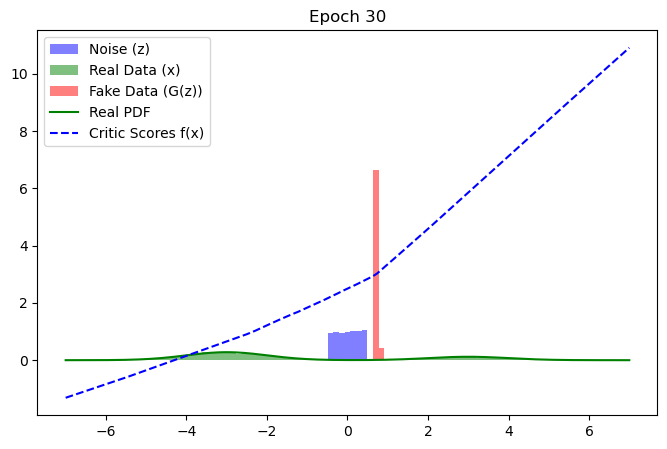

Epoch 31/50: G=-3.038, C_real=2.168, C_fake=3.039, W_Dist=-0.871, GP=0.117
Epoch 32/50: G=-3.289, C_real=2.256, C_fake=3.294, W_Dist=-1.038, GP=0.126
Epoch 33/50: G=-3.576, C_real=2.339, C_fake=3.577, W_Dist=-1.238, GP=0.140
Epoch 34/50: G=-3.848, C_real=2.387, C_fake=3.853, W_Dist=-1.466, GP=0.160
Epoch 35/50: G=-4.226, C_real=2.530, C_fake=4.225, W_Dist=-1.695, GP=0.186


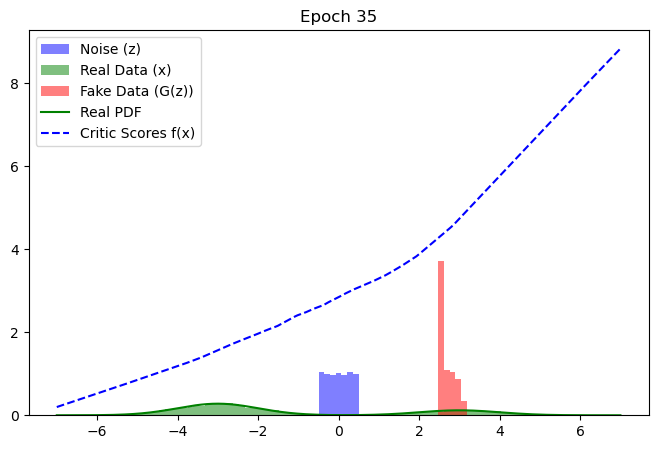

Epoch 36/50: G=-4.530, C_real=2.563, C_fake=4.531, W_Dist=-1.968, GP=0.222
Epoch 37/50: G=-4.766, C_real=2.639, C_fake=4.764, W_Dist=-2.125, GP=0.278
Epoch 38/50: G=-4.739, C_real=2.607, C_fake=4.740, W_Dist=-2.133, GP=0.356
Epoch 39/50: G=-4.559, C_real=2.576, C_fake=4.559, W_Dist=-1.983, GP=0.463
Epoch 40/50: G=3.175, C_real=2.695, C_fake=-3.095, W_Dist=5.791, GP=0.374


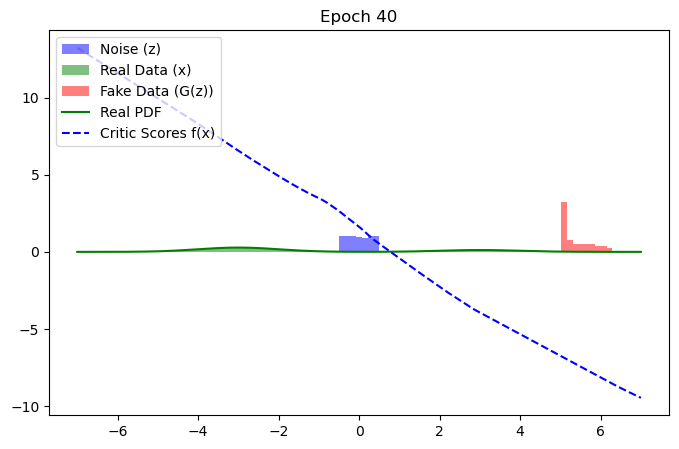

Epoch 41/50: G=6.476, C_real=3.707, C_fake=-6.466, W_Dist=10.173, GP=0.419
Epoch 42/50: G=4.853, C_real=3.656, C_fake=-4.850, W_Dist=8.506, GP=0.326
Epoch 43/50: G=3.299, C_real=3.769, C_fake=-3.306, W_Dist=7.075, GP=0.251
Epoch 44/50: G=2.168, C_real=3.823, C_fake=-2.170, W_Dist=5.992, GP=0.204
Epoch 45/50: G=1.525, C_real=3.567, C_fake=-1.525, W_Dist=5.093, GP=0.178


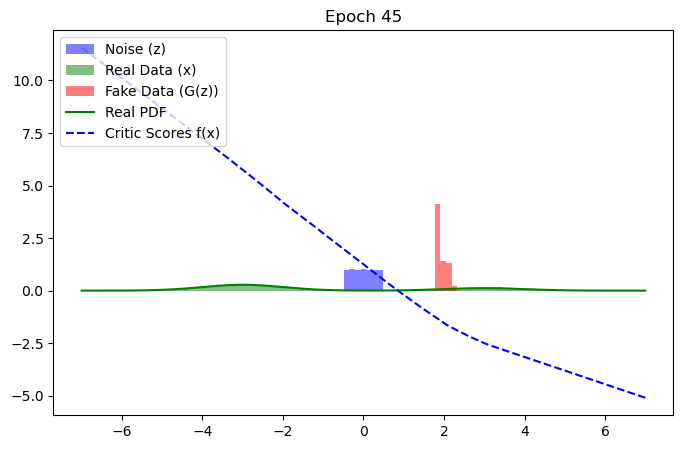

Epoch 46/50: G=1.222, C_real=3.183, C_fake=-1.219, W_Dist=4.402, GP=0.158
Epoch 47/50: G=1.079, C_real=2.781, C_fake=-1.079, W_Dist=3.860, GP=0.141
Epoch 48/50: G=0.971, C_real=2.418, C_fake=-0.973, W_Dist=3.391, GP=0.127
Epoch 49/50: G=0.826, C_real=2.275, C_fake=-0.826, W_Dist=3.102, GP=0.117
Epoch 50/50: G=0.641, C_real=2.140, C_fake=-0.641, W_Dist=2.781, GP=0.109


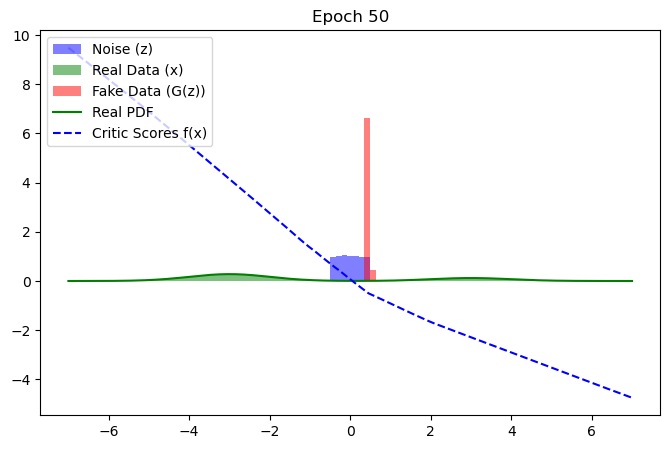

In [48]:
for epoch in range(epochs):
    
    loss_g_running = 0.0
    loss_c_real_running = 0.0
    loss_c_fake_running = 0.0
    loss_gp_running = 0.0
    
    for i in range(batches_per_epoch):
        
        for _ in range(n_critic):
            lcr_, lcf_, lgp_ = gan.train_step_C()
            loss_c_real_running += lcr_
            loss_c_fake_running += lcf_
            loss_gp_running += lgp_

        lg_ = gan.train_step_G()
        loss_g_running += lg_
    
    avg_g_loss = loss_g_running / batches_per_epoch
    avg_c_real_loss = loss_c_real_running / (batches_per_epoch * n_critic)
    avg_c_fake_loss = loss_c_fake_running / (batches_per_epoch * n_critic)
    avg_gp_loss = loss_gp_running / (batches_per_epoch * n_critic)
    
    wasserstein_dist = avg_c_real_loss - avg_c_fake_loss
    
    print(f"Epoch {epoch+1}/{epochs}: "
          f"G={avg_g_loss:.3f}, C_real={avg_c_real_loss:.3f}, C_fake={avg_c_fake_loss:.3f}, "
          f"W_Dist={wasserstein_dist:.3f}, GP={avg_gp_loss:.3f}")

    if epoch == 0 or (epoch+1) % 5 == 0:
        visualize_GAN(
            noise_fn(5000).cpu().numpy(),
            data_fn(5000).cpu().numpy(),
            gan.generate_samples(num=5000).cpu().numpy(),
            gan.C,
            data_pdf,
            title=f"Epoch {epoch+1}",
            is_critic=True
        )


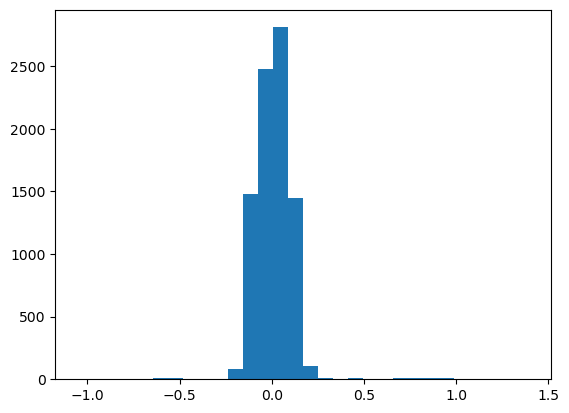

In [49]:
params = []
for param in C.parameters():
    params.extend(param.detach().cpu().numpy().flatten())
plt.hist(params, bins=30)
plt.show()

### WGAN-GP on MNIST

In [50]:
n_epochs = 20
batch_size = 128
lr = 5e-4
b1 = 0.5            
b2 = 0.9            
latent_dim = 128 
img_size = 28
channels = 1
n_critic = 5        
lambda_gp = 10     

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_shape = (channels, img_size, img_size)
img_flat_dim = int(np.prod(img_shape))

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
val_dataset = MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [51]:
class Generator(nn.Module):
    def __init__(self, hiddens):
        super().__init__()
        layers = []
        for in_dim, out_dim in zip(hiddens[:-1], hiddens[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            if out_dim != hiddens[-1]:
                layers.append(nn.BatchNorm1d(out_dim, 0.8))
                layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        layers.append(nn.Tanh())
        self.model = nn.Sequential(*layers)

    def forward(self, z):
        img_flat = self.model(z)
        return img_flat.view(img_flat.size(0), *img_shape)

class Critic(nn.Module):
    def __init__(self, hiddens):
        super().__init__()
        layers = []
        for in_dim, out_dim in zip(hiddens[:-1], hiddens[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            if out_dim != hiddens[-1]:
                layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        self.model = nn.Sequential(*layers)

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [52]:
class WGAN_GP:
    def __init__(self, G, C, device, n_critic, lambda_gp, lr, b1, b2):
        self.G = G.to(device)
        self.C = C.to(device)
        self.device = device
        self.n_critic = n_critic
        self.lambda_gp = lambda_gp
        
        self.optim_C = optim.Adam(C.parameters(), lr=lr, betas=(b1, b2))
        self.optim_G = optim.Adam(G.parameters(), lr=lr, betas=(b1, b2))

    def generate_samples(self, z_sample) -> torch.Tensor:
        with torch.no_grad():
            samples = self.G(z_sample)
        return samples

    def compute_gradient_penalty(self, real_samples, fake_samples, current_batch_size):        
        alpha = torch.rand(current_batch_size, 1, 1, 1, device=self.device)
        interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
        
        critic_interpolates = self.C(interpolates)
        
        fake_grad_outputs = torch.ones(current_batch_size, 1, device=self.device)
        
        gradients = autograd.grad(
            outputs=critic_interpolates,
            inputs=interpolates,
            grad_outputs=fake_grad_outputs,
            create_graph=True,
            retain_graph=True,
        )[0]
        
        gradients = gradients.view(gradients.size(0), -1)
        gradient_norm = gradients.norm(2, dim=1)
        
        gradient_penalty = ((gradient_norm - 1) ** 2).mean()
        return gradient_penalty

    def train_step_C(self, real_samples, z, current_batch_size) -> tuple[float, float, float]:
        self.C.zero_grad()

        real_scores = self.C(real_samples)

        with torch.no_grad():
            fake_samples = self.G(z)
        fake_scores = self.C(fake_samples)

        # Loss: max [E[f(x)] - E[f(G(z))]] -> min [E[f(G(z))] - E[f(x)]]
        loss_C_original = (fake_scores.mean()) - (real_scores.mean())
        
        gp = self.compute_gradient_penalty(real_samples, fake_samples, current_batch_size)
        
        loss_C = loss_C_original + self.lambda_gp * gp
        
        loss_C.backward()
        self.optim_C.step()
        
        return real_scores.mean().item(), fake_scores.mean().item(), gp.item()

    def train_step_G(self, z) -> float:
        self.G.zero_grad()
        
        fake_samples = self.G(z)
        fake_scores = self.C(fake_samples)

        # Loss: min [-E[f(G(z))]]
        loss_G = -fake_scores.mean()
        
        loss_G.backward()
        self.optim_G.step()
        
        return loss_G.item()

In [59]:
def show_generated_images(gan, num_images=10, title=""):
    gan.G.eval()
    
    z_sample = torch.randn(num_images, latent_dim, device=device)
    gen_imgs = gan.generate_samples(z_sample)
    
    gen_imgs = gen_imgs * 0.5 + 0.5
    
    grid = make_grid(gen_imgs, nrow=num_images, normalize=True)
    
    plt.figure(figsize=(10, 2))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

def plot_losses(g_losses, w_dists, gp_losses):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(g_losses)
    plt.title('Generator Loss')
    plt.xlabel('Epoch')
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(w_dists)
    plt.title('Wasserstein Distance')
    plt.xlabel('Epoch')
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot(gp_losses)
    plt.title('Gradient Penalty')
    plt.xlabel('Epoch')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [60]:
gen_hiddens = [latent_dim, 128, 256, 512, 1024, img_flat_dim]
dis_hiddens = [img_flat_dim, 512, 256, 1]

G = Generator(gen_hiddens).to(device)
C = Critic(dis_hiddens).to(device)
gan = WGAN_GP(G, C, device, n_critic, lambda_gp, lr, b1, b2)

g_losses_epoch = []
w_dists_epoch = []
gp_losses_epoch = []

Epoch 20/20
G loss: -1.4216, W-Dist: 1.0432, GP: 0.0080


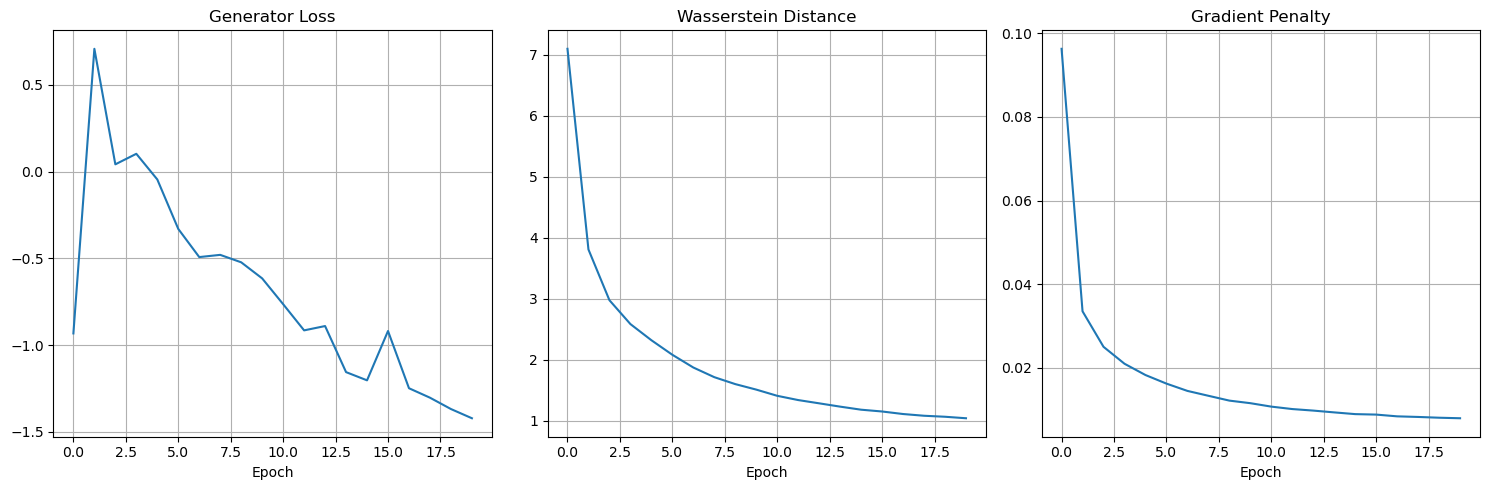

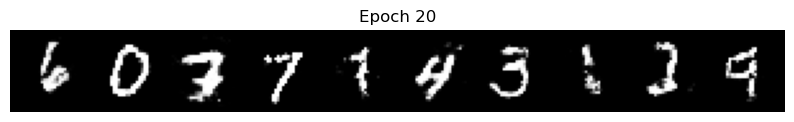

In [61]:
for epoch in range(n_epochs):
    
    epoch_g_loss = []
    epoch_w_dist = []
    epoch_gp_loss = []
    
    for i, (real_imgs, _) in enumerate(train_loader):

        real_imgs = real_imgs.to(device)
        current_batch_size = real_imgs.size(0)

        gan.C.train()
        gan.G.eval()
        
        loss_c_real_avg = 0.0
        loss_c_fake_avg = 0.0
        gp_avg = 0.0

        for _ in range(n_critic):
            z = torch.randn(current_batch_size, latent_dim, device=device)
            lcr_, lcf_, gp_ = gan.train_step_C(real_imgs, z, current_batch_size)
            loss_c_real_avg += lcr_
            loss_c_fake_avg += lcf_
            gp_avg += gp_

        gan.G.train()
        gan.C.eval()
        
        z = torch.randn(current_batch_size, latent_dim, device=device)
        loss_G = gan.train_step_G(z)
        
        loss_c_real_avg /= n_critic
        loss_c_fake_avg /= n_critic
        gp_avg /= n_critic
        w_dist = loss_c_real_avg - loss_c_fake_avg
        
        epoch_g_loss.append(loss_G)
        epoch_w_dist.append(w_dist)
        epoch_gp_loss.append(gp_avg)
    
    clear_output(wait=True)
    
    avg_g = np.mean(epoch_g_loss)
    avg_w = np.mean(epoch_w_dist)
    avg_gp = np.mean(epoch_gp_loss)
    
    g_losses_epoch.append(avg_g)
    w_dists_epoch.append(avg_w)
    gp_losses_epoch.append(avg_gp)

    print(f"Epoch {epoch+1}/{n_epochs}")
    print(f"G loss: {avg_g:.4f}, W-Dist: {avg_w:.4f}, GP: {avg_gp:.4f}")
    
    plot_losses(g_losses_epoch, w_dists_epoch, gp_losses_epoch)
    show_generated_images(gan, num_images=10, title=f"Epoch {epoch+1}")

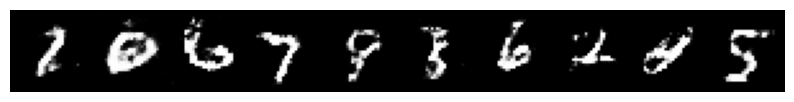

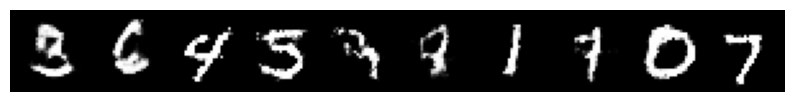

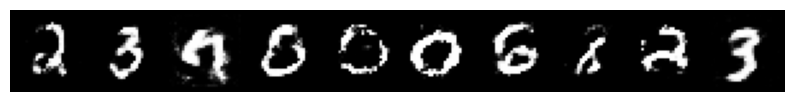

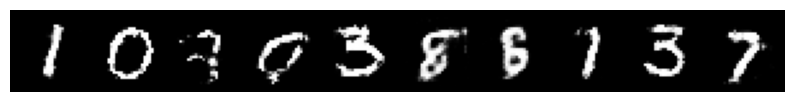

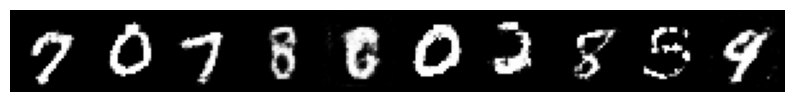

In [62]:
for i in range(5):
    show_generated_images(gan, num_images=10)